# Federated Learning for Melanoma Classification

## Objective 1: Developing a classification model for Melanoma

### Loading data & exploratory data analysis

### Import Modules & Packages

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import time
import pickle
import random
import sklearn


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import  confusion_matrix, roc_curve

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from torch.cuda import amp
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from utils import *
from Visualise import *
from ResizeImages import *
from MelanomaDataset import *
from MelanomaEfficientNet import *
from TrainVal import *
from Test import *
from Plot import *
from FocalLoss import *

In [2]:
# Install package for model
#!pip install efficientnet_pytorch

### Package Versions

In [3]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"Torch: {torch.__version__}")

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.21.2
matplotlib: 3.4.3
sklearn: 0.24.2
Torch: 1.8.0+cu111


### Set directory, seed & device

In [4]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\Research Project\\Federated-Learning-Melanoma'

In [5]:
# Seed everything
set_seed(random_seed=5)

In [6]:
# Set device to GPU if available
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Part I: Loading SIIM-ISIC Melanoma Dataset & Pre-processing

In [9]:
# Loading metadata
data_dir= os.path.join('Data')
train_metadata_df = pd.read_csv(data_dir + "/Train_Metadata.csv")
test_metadata_df= pd.read_csv(data_dir + "/Test_Metadata.csv")

In [3]:
train_metadata_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [4]:
# NOTE: TEST DATA IS UNLABELLED- TRAIN DATA ONLY WILL BE USED TO FORM TRAIN, VAL & TEST DATASPLITS
test_metadata_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

In [16]:
# Shape of training dataset (samples x features)
print('Training Shape: {}'.format(train_metadata_df.shape))

Training Shape: (33126, 8)


### Data Cleansing
#### Null value handling for features in train metadata, to enable effective generation of  heterogenous data splits for Federated Learning exploration.

In [17]:
# Checking for Null values in training metadata 
train_metadata_df.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [8]:
# Check whether fields containing Null values for Sex are also present in other columns - 65 rows overlap
print(train_metadata_df[train_metadata_df['sex'].isna()].isna().sum())

# Check if these 65 values contain malignant or benign images
Null_Sex_Age_class= train_metadata_df[train_metadata_df['sex'].isna()]['benign_malignant'].unique()
print("Classification types for images containing Nulls in Sex & Age fields:", Null_Sex_Age_class)

# Remaining 3 rows containing Null values in Age column only
print(train_metadata_df[(~train_metadata_df['sex'].isna())&train_metadata_df['age_approx'].isna()].isna().sum())

# Check whether remaining 3 rows of Null Values in the Age column contain malignant or benign images
Null_Age_only_class=train_metadata_df[(~train_metadata_df['sex'].isna())&train_metadata_df['age_approx'].isna()]['benign_malignant'].unique()
print("Classification types for images containing Nulls Age field only:", Null_Age_only_class)



image_name                        0
patient_id                        0
sex                              65
age_approx                       65
anatom_site_general_challenge     0
diagnosis                         0
benign_malignant                  0
target                            0
dtype: int64
Classification types for images containing Nulls in Sex & Age fields: ['benign']
image_name                       0
patient_id                       0
sex                              0
age_approx                       3
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64
Classification types for images containing Nulls Age field only: ['benign']


In [10]:
# Create copy of metadata and drop nulls
train_metadata_proc=train_metadata_df.copy()
train_metadata_proc= train_metadata_proc[(~train_metadata_df['sex'].isna())&(~train_metadata_df['age_approx'].isna())]
train_metadata_proc.reset_index(inplace=True)
train_metadata_proc.drop(columns=['index'],inplace=True)
train_metadata_proc

image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33053  ISIC_9999134  IP_6526534    male        50.0   
33054  ISIC_9999320  IP_3650745    male        65.0   
33055  ISIC_9999515  IP_2026598    male        20.0   
33056  ISIC_9999666  IP_7702038    male        50.0   
33057  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown           benign       0  
4                   upper extremity   unknown           benign       0  
...                             ...       ...              ...     ...  
33053                         torso   unknown           benign       0  
33054                         torso   unknown           benign       0  
33055               lower extremity   unknown           benign       0  
33056               lower extremity   unknown           benign       0  
33057                         torso     nevus           benign       0  

[33058 rows x 8 columns]

In [10]:
# Check class types present in Null anatomical site column - contains malignant images
print(train_metadata_proc[train_metadata_proc['anatom_site_general_challenge'].isna()]['benign_malignant'].unique())

# Check unique values of anatom_site_general_challenge
print(train_metadata_proc['anatom_site_general_challenge'].unique())

# Replace nan values with unknown
train_metadata_proc['anatom_site_general_challenge'].fillna("unknown", inplace=True)

# Check
train_metadata_proc


['benign' 'malignant']
['head/neck' 'upper extremity' 'lower extremity' 'torso' nan 'palms/soles'
 'oral/genital']


image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33053  ISIC_9999134  IP_6526534    male        50.0   
33054  ISIC_9999320  IP_3650745    male        65.0   
33055  ISIC_9999515  IP_2026598    male        20.0   
33056  ISIC_9999666  IP_7702038    male        50.0   
33057  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown           benign       0  
4                   upper extremity   unknown           benign       0  
...                             ...       ...              ...     ...  
33053                         torso   unknown           benign       0  
33054                         torso   unknown           benign       0  
33055               lower extremity   unknown           benign       0  
33056               lower extremity   unknown           benign       0  
33057                         torso     nevus           benign       0  

[33058 rows x 8 columns]

In [214]:
# Save processed metadata to file
train_metadata_proc.to_csv(data_dir + "/Train_Metadata_Processed.csv")

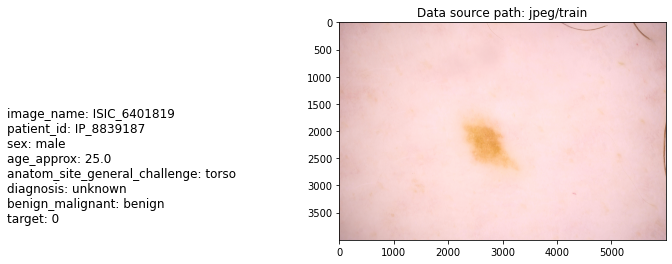

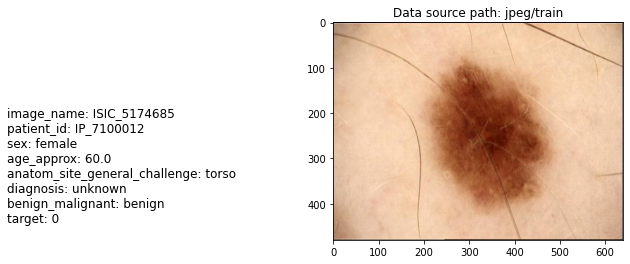

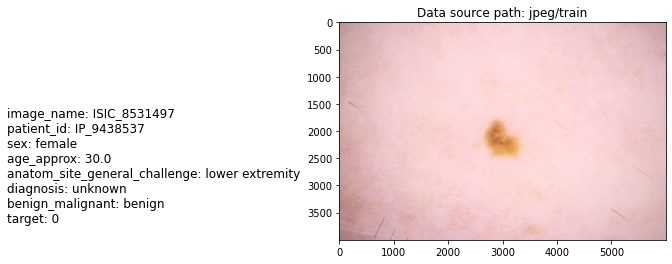

In [2]:
# Check original images and corresponding data - BENIGN
visualise_jpeg("jpeg","train", n_images=3, target=0)

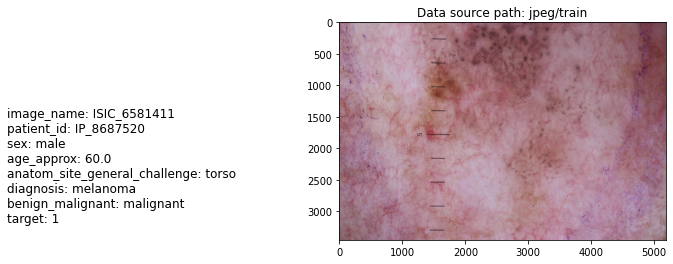

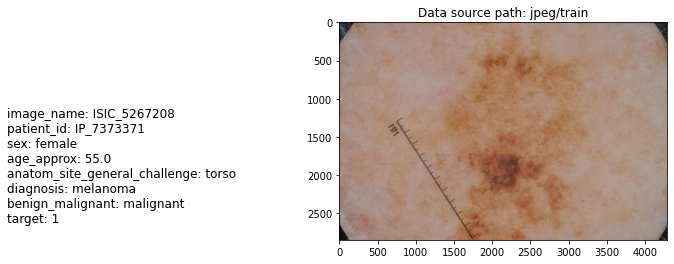

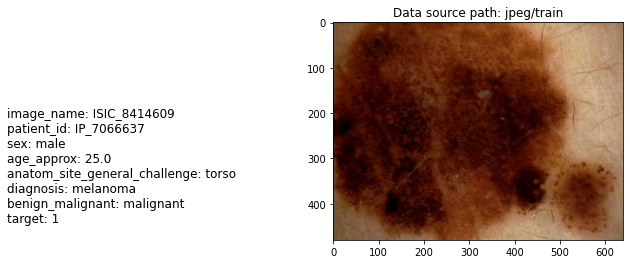

In [3]:
# Check original images and corresponding data- MALIGNANT
visualise_jpeg("jpeg","train", n_images=3, target=1)

#### Investigating the size of images to decide on a resizing approach:

In [12]:
#Image sizes
image_sizes = get_image_size("train")

# Save train image sizes df to csv
image_sizes.to_csv("train_image_sizes.csv")

In [13]:
# Minimum image size
print("Minimum size of image in dataset:", image_sizes.min())

# Number of images with the minimum image size in train
min_count=image_sizes[(image_sizes['width']==image_sizes['width'].min())&
           (image_sizes['height']==image_sizes['height'].min())].count()

print("Number of images with min size in dataset", min_count)

Minimum size of image in dataset: image_name    ISIC_0015719
width                  640
height                 480
dtype: object
Number of images with min size in dataset image_name    4147
width         4147
height        4147
dtype: int64


In [14]:
# Image ratios 
image_sizes['ratio']=image_sizes['width']/image_sizes['height']
image_sizes['ratio'].describe()

count    33126.000000
mean         1.527957
std          0.155173
min          0.664179
25%          1.500000
50%          1.500000
75%          1.500000
max          1.781473
Name: ratio, dtype: float64

Text(0.5, 1.0, 'Distribution of Image Sizes in Dataset')

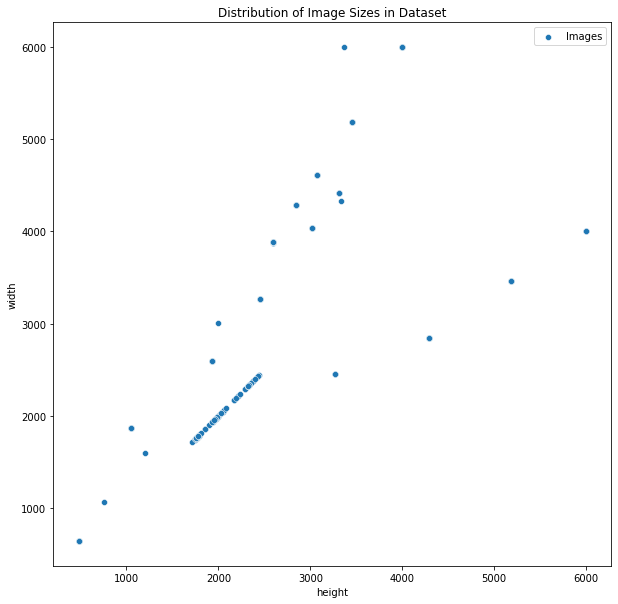

In [15]:
# Plot distribution of image sizes

# Plot distribution of  image sizes
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x= image_sizes["height"], y=image_sizes["width"], label="Images")
plt.legend()
plt.title("Distribution of Image Sizes in Dataset")



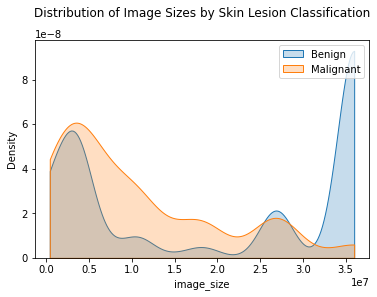

In [21]:
#Distribution of Image Sizes by Skin Lesion Classification
image_size_metadata=train_metadata_proc.merge(image_sizes, how="inner", on="image_name")
image_size_metadata["image_size"]=image_size_metadata["width"]*image_size_metadata["width"]

max_image_size=image_size_metadata['image_size'].max()
min_image_size=image_size_metadata['image_size'].min()

sns.kdeplot(image_size_metadata[image_size_metadata['target']==0]['image_size'], label="Benign", shade=True, clip=(min_image_size, max_image_size))
sns.kdeplot(image_size_metadata[image_size_metadata['target']==1]['image_size'], label="Malignant", shade=True, clip=(min_image_size, max_image_size))
plt.title("Distribution of Image Sizes by Skin Lesion Classification", y=1.08)
plt.legend()
plt.show()

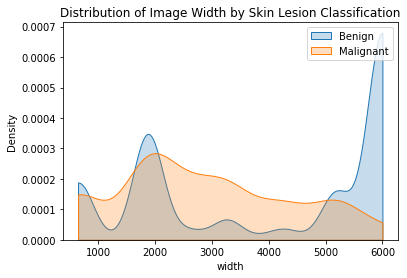

In [29]:
#Distribution of Image Width by Skin Lesion Classification

max_width=image_size_metadata['width'].max()
min_width=image_size_metadata['width'].min()

sns.kdeplot(image_size_metadata[image_size_metadata['target']==0]['width'], label="Benign", shade=True, clip=(min_width,max_width))
sns.kdeplot(image_size_metadata[image_size_metadata['target']==1]['width'], label="Malignant", shade=True, clip=(min_width, max_width))
plt.title("Distribution of Image Width by Skin Lesion Classification")
plt.legend()


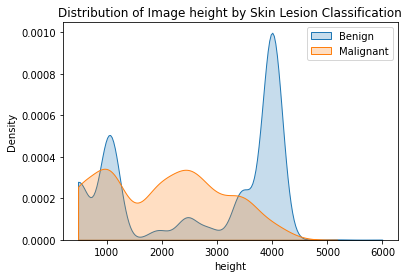

In [30]:
#Distribution of Image height by Skin Lesion Classification

max_height=image_size_metadata['height'].max()
min_height=image_size_metadata['height'].min()

sns.kdeplot(image_size_metadata[image_size_metadata['target']==0]['height'], label="Benign", shade=True, clip=(min_height,max_height))
sns.kdeplot(image_size_metadata[image_size_metadata['target']==1]['height'], label="Malignant", shade=True, clip=(min_height,max_height))
plt.title("Distribution of Image height by Skin Lesion Classification")
plt.legend() 

#### Resize images: center crop and resize to 256x256 (approach aims to retain aspect ratio and resize for uniform and faster processing)

In [67]:
# Center crop and resize training images to 256x256 - ~3hrs to run 
resize_images("train", 256)

In [34]:
# Number of images in original dataset
print('Number of original Training Images:', len(os.listdir(data_dir + "/jpeg/train")))

# Number of images in processed dataset
print('Number of processed Training Images:', len(os.listdir(data_dir + "/jpeg_crop_resize_256x256/train")))

Number of original Training Images: 33126
Number of processed Training Images: 33058


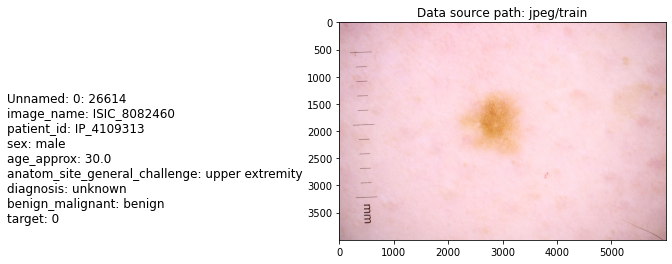

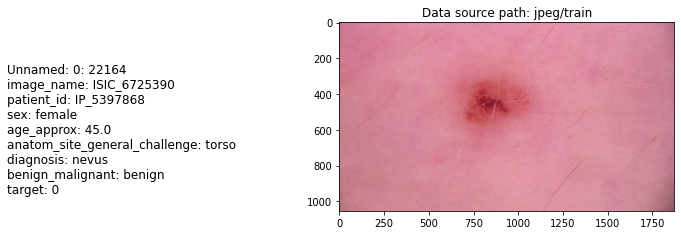

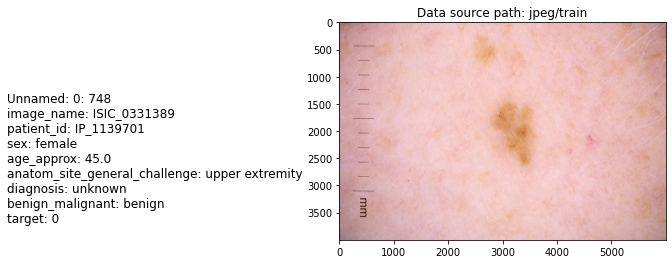

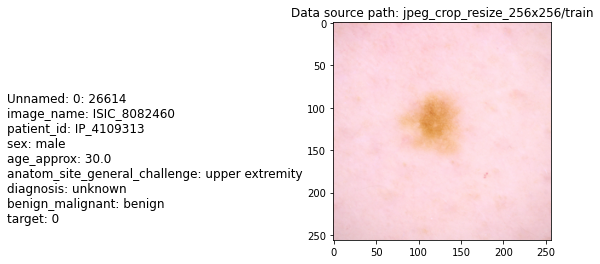

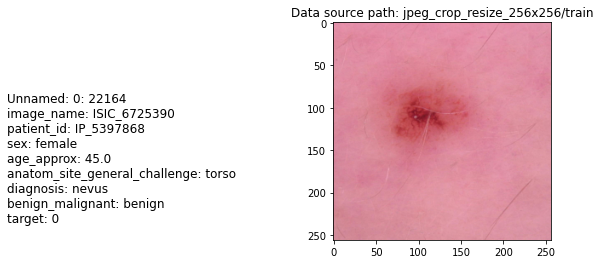

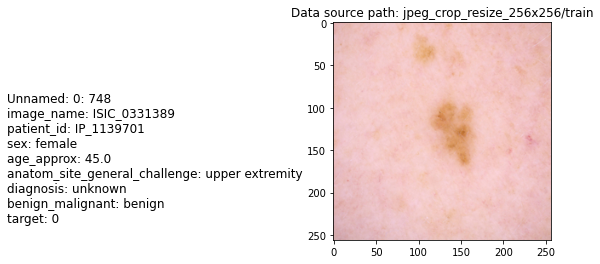

In [35]:
# Visualise resized images compared to original images - BENIGN
visualise_jpeg("jpeg","train", n_images=3, target=0, seed=5, metadata_processed=True)
visualise_jpeg("jpeg_crop_resize_256x256","train", n_images=3, target=0, seed=5, metadata_processed=True)

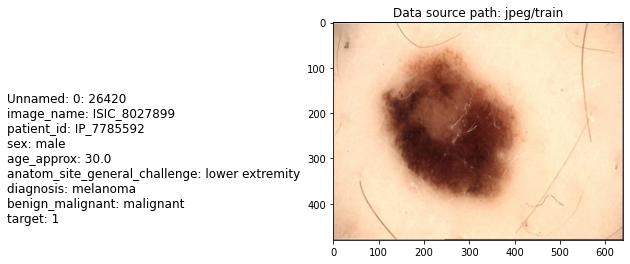

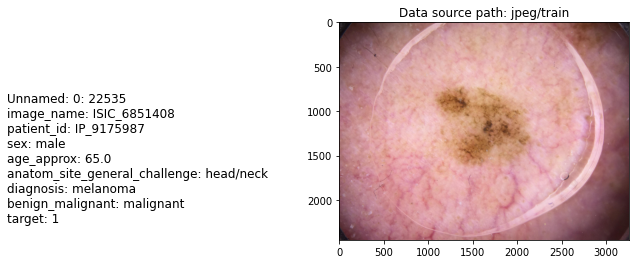

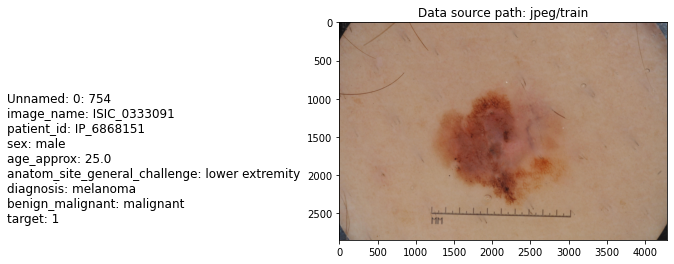

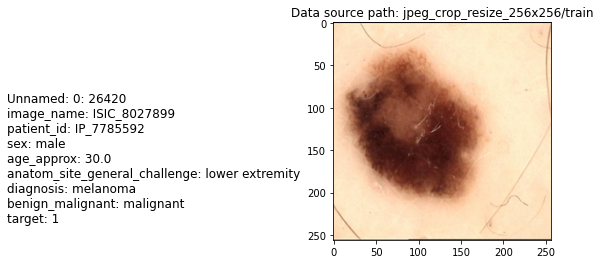

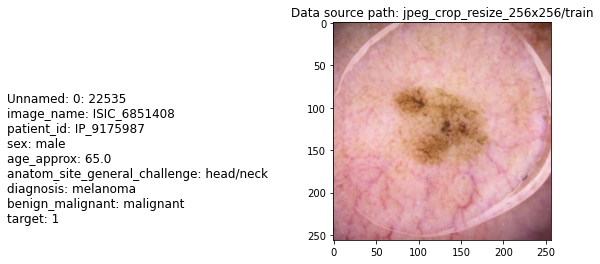

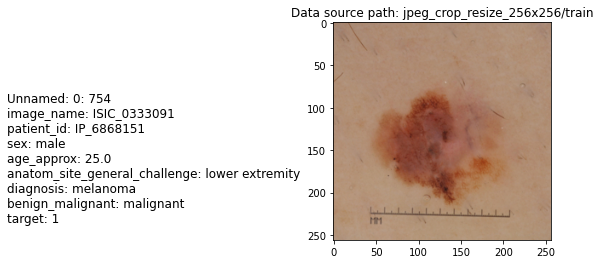

In [36]:
# Visualise resized images compared to original images - Malignant
visualise_jpeg("jpeg","train", n_images=3, target=1, seed=5, metadata_processed=True)
visualise_jpeg("jpeg_crop_resize_256x256","train", n_images=3, target=1, seed=5, metadata_processed=True)

#### Check for duplicates:

In [37]:
# Check all image names are unique
print('Total number of images:', train_metadata_proc['image_name'].value_counts().sum())
print('Total number of unique images:', train_metadata_proc['image_name'].nunique())

Total number of images: 33058
Total number of unique images: 33058


## Part II: Exploratory Data Analysis 

### Exploring images by metadata

#### Distribution of skin lesions by target

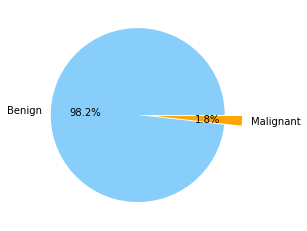

In [7]:
# Ratio of benign vs malignant (98.2% Benign vs 1.8% Malignant)
target_dist = train_metadata_proc.benign_malignant.value_counts()
target_labels= ["Benign", "Malignant"]
colors=['lightskyblue', 'orange']
plt.pie(target_dist, explode=(0,0.2), labels=target_labels, autopct='%1.1f%%', colors=colors)
plt.show()

#### Distribution of skin lesions by Sex & Age

Distribution by gender %: 
 male      51.666767
female    48.333233
Name: sex, dtype: float64


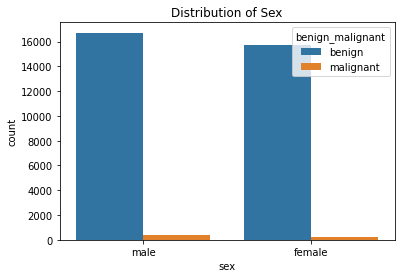

In [39]:
# Distribution of Sex in dataset (51.7% male, 48.3% female)

#print("Distribution by gender:", "\n",train_metadata_proc["sex"].value_counts())
print("Distribution by gender %:", "\n",(train_metadata_proc["sex"].value_counts( normalize=True))* 100)

gender= train_metadata_proc["sex"]
benign_malignant= train_metadata_proc["benign_malignant"]
sns.countplot(x=gender,hue=benign_malignant)
plt.title("Distribution of Sex")
plt.show()

In [41]:
# Distribution of benign and malignant samples by gender:

male_samples=train_metadata_proc[train_metadata_proc["sex"]=="male"]
print("Distribution of Benign/Malignant samples for males:","\n",male_samples["benign_malignant"].value_counts(normalize=True)*100)

Distribution of Benign/Malignant samples for males: 
 benign       97.868852
malignant     2.131148
Name: benign_malignant, dtype: float64


In [42]:
female_samples=train_metadata_proc[train_metadata_proc["sex"]=="female"]
print("Distribution of Benign/Malignant samples for females:","\n",female_samples["benign_malignant"].value_counts(normalize=True)*100)


Distribution of Benign/Malignant samples for females: 
 benign       98.623107
malignant     1.376893
Name: benign_malignant, dtype: float64


Text(0.5, 1.0, 'Age Distribution')

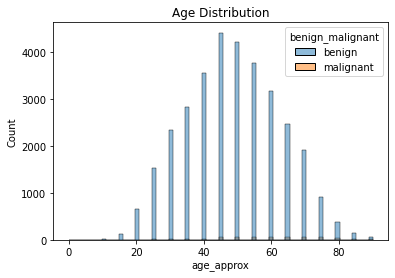

In [43]:
# Distribution of Age
age_dist=train_metadata_proc['age_approx']
benign_malignant= train_metadata_proc["benign_malignant"]
sns.histplot(x=age_dist, hue=benign_malignant)
plt.title("Age Distribution")

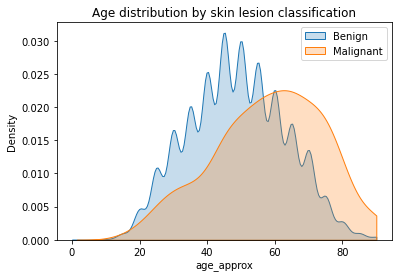

In [44]:
# Distribution of Age in relation to Benign/malignant target
benign_age= train_metadata_proc.loc[train_metadata_proc["benign_malignant"]=="benign", 'age_approx']
malignant_age= train_metadata_proc.loc[train_metadata_proc["benign_malignant"]=="malignant", 'age_approx']
min_age=train_metadata_proc["age_approx"].min()
max_age=train_metadata_proc["age_approx"].max()
fig,ax=plt.subplots()
sns.kdeplot(benign_age, label="Benign", ax=ax, shade=True, clip=(min_age, max_age))
sns.kdeplot(malignant_age, label="Malignant", ax=ax, shade=True, clip=(min_age, max_age))
plt.legend()
plt.title ("Age distribution by skin lesion classification")
plt.show()

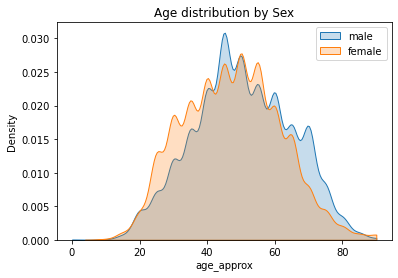

In [45]:
# Distribution of Age by gender
benign_sex= train_metadata_proc.loc[train_metadata_proc["sex"]=="male", 'age_approx']
malignant_sex= train_metadata_proc.loc[train_metadata_proc["sex"]=="female", 'age_approx']
min_age=train_metadata_proc["age_approx"].min()
max_age=train_metadata_proc["age_approx"].max()
fig,ax=plt.subplots()
sns.kdeplot(benign_sex, label="male", ax=ax, shade=True, clip=(min_age, max_age))
sns.kdeplot(malignant_sex, label="female", ax=ax, shade=True, clip=(min_age, max_age))
plt.legend()
plt.title ("Age distribution by Sex")
plt.show()

Text(0.5, 1.0, 'Distribution of Skin lesion classification by Age and Sex')

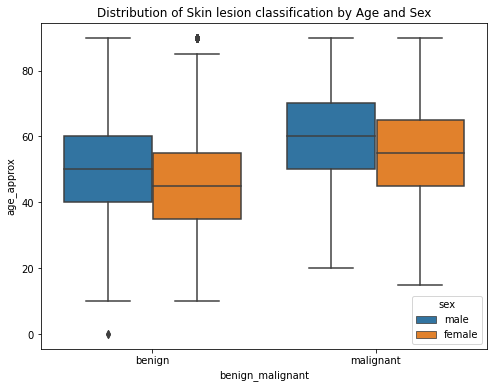

In [46]:
# Distribution of Skin lesion classification by Age and Sex
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_metadata_proc["benign_malignant"], y= train_metadata_proc["age_approx"], hue=train_metadata_proc["sex"])
plt.title("Distribution of Skin lesion classification by Age and Sex")

#### Location of skin lesion distribution

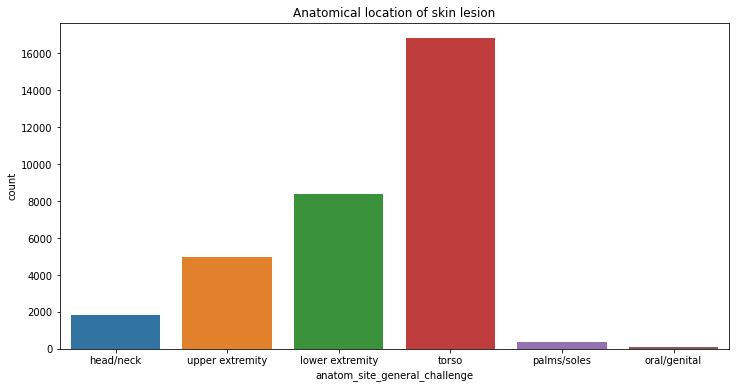

In [48]:
# Anatomical Location of skin lesion 
location= train_metadata_proc['anatom_site_general_challenge']
plt.figure(figsize=(12, 6))
sns.countplot(x=location)
plt.title("Anatomical location of skin lesion")
plt.show()

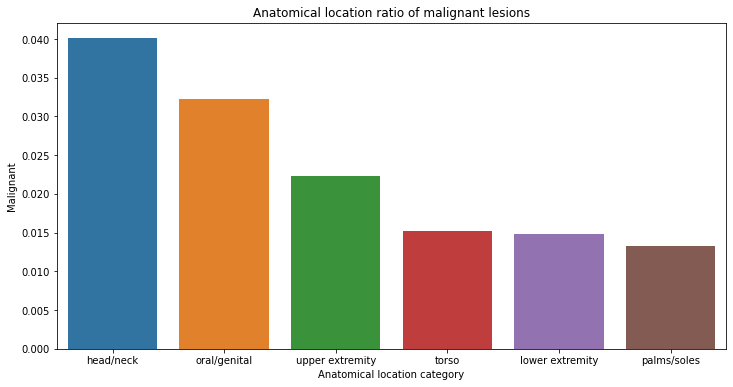

In [49]:
#Anatomical Location of skin lesion by classification Benign/Malignant 
plt.figure(figsize=(12, 6))
Malignant_freq= train_metadata_proc.groupby("anatom_site_general_challenge")["target"].mean().sort_values(ascending=False) # benign is 0, malignant is 1 so mean provides the ratio
sns.barplot(x=Malignant_freq.index, y=Malignant_freq)
plt.xlabel("Anatomical location category")
plt.ylabel("Malignant")
plt.title ("Anatomical location ratio of malignant lesions")
plt.show()




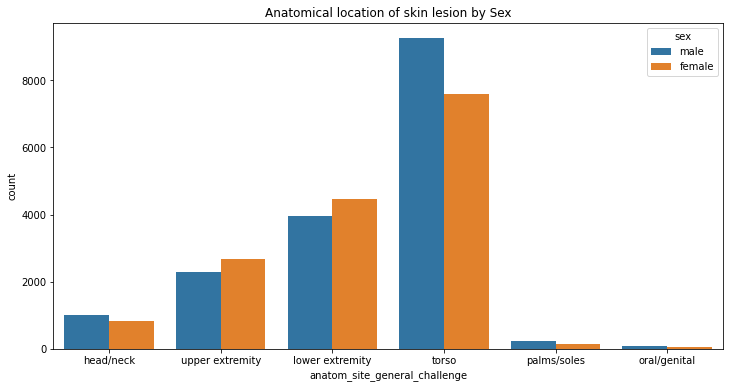

In [50]:
# Anatomical Location of skin lesion by Sex
plt.figure(figsize=(12, 6))
sns.countplot(x=train_metadata_proc['anatom_site_general_challenge'], hue=train_metadata_proc['sex'])
plt.title ("Anatomical location of skin lesion by Sex")
plt.show()

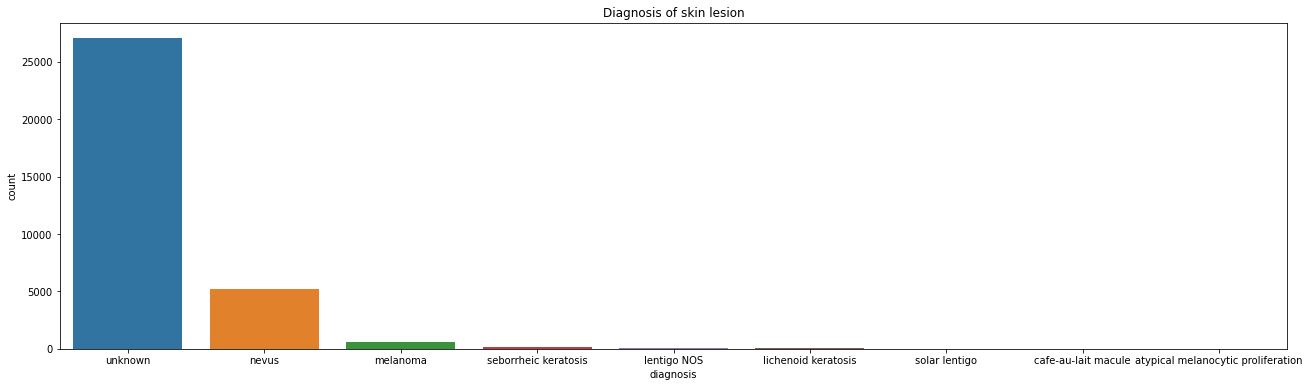

In [51]:
# Diagnosis
plt.figure(figsize=(22, 6))
sns.countplot(x=train_metadata_proc['diagnosis'])
plt.title ("Diagnosis of skin lesion")
plt.show()

#### Patient & Image size distribution

Number of unique Patient ID's: 2053
Average number of images per patient: 112.45932781295666


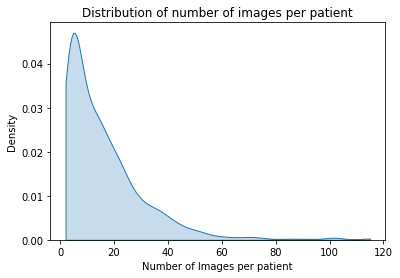

In [52]:
# Number of patients
print("Number of unique Patient ID's:", train_metadata_proc['patient_id'].nunique())

print("Average number of images per patient:", train_metadata_proc.groupby(['patient_id']).count().mean().sum())

plt.figure()
num_imgs_patient=train_metadata_proc.groupby(['patient_id'])['image_name'].count()
imgs_min=num_imgs_patient.min()
imgs_max=num_imgs_patient.max()
sns.kdeplot(x=num_imgs_patient, shade=True, clip=(imgs_min, imgs_max))
plt.xlabel("Number of Images per patient")
plt.title("Distribution of number of images per patient")
plt.show()


In [53]:
# Number of Original Image Size Categories # Could be indicative of different systems used for imaging
image_sizes["dimensions"]= image_sizes["width"].astype(str)+"x"+ image_sizes["height"].astype(str)

img_dim_counts=image_sizes['dimensions'].value_counts()
img_dim_unique=image_sizes['dimensions'].nunique()

print("Image dimension types:", img_dim_counts)
print("Image dimension unique combinations:", img_dim_unique)


Image dimension types: 6000x4000    14703
1872x1053     7534
640x480       4147
5184x3456     3418
3264x2448     1483
             ...  
2229x2229        1
2353x2353        1
3008x2000        1
1969x1969        1
1979x1979        1
Name: dimensions, Length: 88, dtype: int64
Image dimension unique combinations: 88


#### RGB distribution

In [22]:
image_mean_rgb = get_mean_rgbs("jpeg_crop_resize_256x256","train",metadata_processed=True)

In [23]:
image_mean_rgb.head()

image_name    mean_red  mean_green   mean_blue
0  ISIC_2637011  222.924545  146.477325  166.791458
1  ISIC_0015719  226.776520  174.710754  138.713104
2  ISIC_0052212  200.629181  127.408905  144.026062
3  ISIC_0068279  113.805801   54.262650   52.071136
4  ISIC_0074268  234.788101  181.049789  158.039032

In [24]:
image_size_metadata_rgb=image_mean_rgb.merge(image_size_metadata, how="inner", on="image_name")

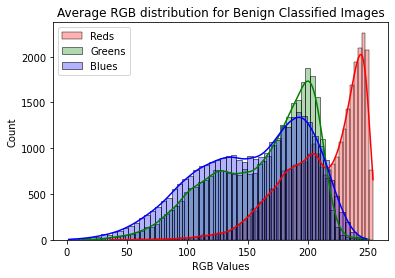

In [25]:
# Plot of average RGB channels for train benign

# Benign
fig=plt.figure()
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['target']==0]["mean_red"], label="Reds", color='red', alpha=0.3, kde=True)
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['target']==0]["mean_green"], label="Greens", color='green', alpha=0.3, kde=True)
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['target']==0]["mean_blue"], label="Blues", color='blue', alpha=0.3, kde=True)
plt.title("Average RGB distribution for Benign Classified Images")
plt.xlabel("RGB Values")
plt.legend()
plt.show()

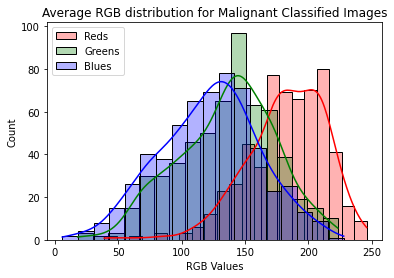

In [26]:
# Plot of average RGB channels for train Malignant
# Malignant
fig=plt.figure()
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['target']==1]["mean_red"], label="Reds", color='red', alpha=0.3, kde=True)
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['target']==1]["mean_green"], label="Greens", color='green', alpha=0.3, kde=True)
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['target']==1]["mean_blue"], label="Blues", color='blue', alpha=0.3, kde=True)
plt.title("Average RGB distribution for Malignant Classified Images")
plt.xlabel("RGB Values")
plt.legend()
plt.show()

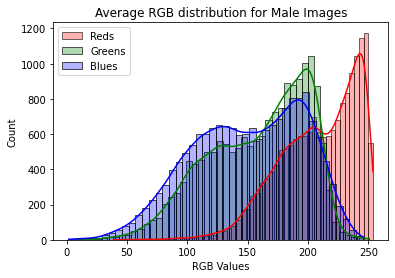

In [27]:
# RGB Channel Distribution for Male patient images
fig=plt.figure()
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['sex']=="male"]["mean_red"], label="Reds", color='red', alpha=0.3, kde=True)
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['sex']=="male"]["mean_green"], label="Greens", color='green', alpha=0.3, kde=True)
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['sex']=="male"]["mean_blue"], label="Blues", color='blue', alpha=0.3, kde=True)
plt.title("Average RGB distribution for Male Images")
plt.xlabel("RGB Values")
plt.legend()
plt.show()

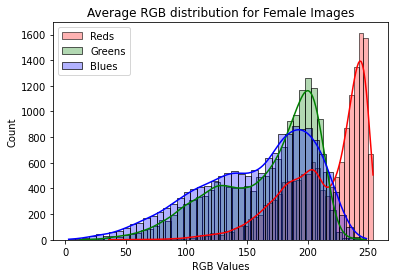

In [28]:
# RGB Channel Distribution for Female patient images
fig=plt.figure()
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['sex']=="female"]["mean_red"], label="Reds", color='red', alpha=0.3, kde=True)
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['sex']=="female"]["mean_green"], label="Greens", color='green', alpha=0.3, kde=True)
sns.histplot(image_size_metadata_rgb[image_size_metadata_rgb['sex']=="female"]["mean_blue"], label="Blues", color='blue', alpha=0.3, kde=True)
plt.title("Average RGB distribution for Female Images")
plt.xlabel("RGB Values")
plt.legend()
plt.show()

<AxesSubplot:>

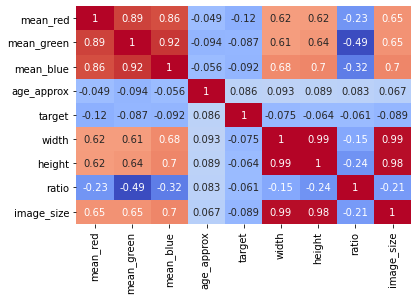

In [61]:
# Correlation of target and attributes
sns.heatmap(image_size_metadata_rgb.corr(), cmap='coolwarm', cbar=False, annot=True)

## Part III: Melanoma Classification Model

### Melanoma Dataset 

In [11]:
# Instantiates the Melanoma dataset -A test run(data subsets are generated using split_datasets which instantiates the dataset)
Trainset=MelanomaDataset(mode='train', img_dir="Data/jpeg_crop_resize_256x256/train/", metadata_dir= "Data/Train_Metadata_Processed.csv", transform=True)

In [3]:
# Check length
Trainset.__len__()

33058

In [2]:
# Split the dataset into train, val and test subsets using stratified split. 
# Split_datasets contains the method to instantiate the dataset

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.8,dataseed=0)

In [3]:
# Check lengths of each set
print("Train set length:", train_set.__len__())
print("Validation set length:",val_set.__len__())
print("Test set length:", test_set.__len__())

Train set length: 23077
Validation set length: 6574
Test set length: 3407


In [4]:
# Check the proportion of malignant skin lesions within each set is similar

train_prop= train_set.metadata_df['target'].value_counts()[1]/len(train_set.metadata_df['target'])
print("Train set proportion of melanoma:" + str(train_prop))

val_prop= val_set.metadata_df['target'].value_counts()[1]/len(val_set.metadata_df['target'])
print("Validation set proportion of melanoma:" + str(val_prop))

test_prop= test_set.metadata_df['target'].value_counts()[1]/len(test_set.metadata_df['target'])
print("Test set proportion of melanoma:" + str(test_prop))

Train set proportion of melanoma:0.017723274255752482
Validation set proportion of melanoma:0.017036811682385154
Test set proportion of melanoma:0.0184913413560317


In [5]:
# Check example image from dataset
image, label= train_set[1]


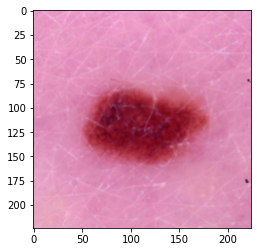

In [7]:
plt.imshow(vis_map_normalize(image).permute(1,2,0))

#### EfficientNet Model

In [9]:
# Load and view pretrained model package from Pytorch
from efficientnet_pytorch import EfficientNet
package_model= EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [10]:
print(package_model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [2]:
# Instantiate and load our MelanomaEfficientNet model - pretrained parameters frozen and classifier added
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [3]:
print(Melanoma_model)

MelanomaEfficientNet(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )


In [4]:
# Instantiate and load MelanomaEfficientNet model with dropout
Melanoma_model_dropout= MelanomaEfficientNetDropout(model='efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [5]:
print(Melanoma_model_dropout)

MelanomaEfficientNetDropout(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
   

## Using pretrained model with partial layers unfrozen

In [7]:
#Using pretrained EfficientNet with last block unfrozen and trainable. No Data augmentation or oversamplign performed
# Oversampling parameter set to 0.02 as per original sampling proportion of 2% melanoma target data
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [13]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0', en_trained_layers=1)
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [14]:
Base_Epoch15_b32_tb0_os0_lr4_blk= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch15_b32_tb0_os0_lr4_blk")


 epoch: 0, train loss: 0.098454, val loss: 0.083281, train acc: 0.9788, val acc: 0.9805, val roc:0.7845



 epoch: 1, train loss: 0.072110, val loss: 0.079137, train acc: 0.9800, val acc: 0.9819, val roc:0.8153



 epoch: 2, train loss: 0.058671, val loss: 0.080956, train acc: 0.9837, val acc: 0.9796, val roc:0.8358



 epoch: 3, train loss: 0.048879, val loss: 0.102244, train acc: 0.9858, val acc: 0.9795, val roc:0.8151



 epoch: 4, train loss: 0.046488, val loss: 0.103001, train acc: 0.9857, val acc: 0.9802, val roc:0.8082



 epoch: 5, train loss: 0.034715, val loss: 0.118652, train acc: 0.9896, val acc: 0.9804, val roc:0.8212



 epoch: 6, train loss: 0.029232, val loss: 0.137168, train acc: 0.9911, val acc: 0.9778, val roc:0.7997



 epoch: 7, train loss: 0.028532, val loss: 0.149447, train acc: 0.9916, val acc: 0.9775, val roc:0.8025



 epoch: 8, train loss: 0.029892, val loss: 0.184154, train acc: 0.9932, val acc: 0.9786, val roc:0.8061



 epoch: 9, train loss: 0.019870, val loss: 0.186655, train acc: 0.9938, val acc: 0.9778, val roc:0.8082



 epoch: 10, train loss: 0.014893, val loss: 0.230635, train acc: 0.9954, val acc: 0.9786, val roc:0.7972



 epoch: 11, train loss: 0.018248, val loss: 0.233190, train acc: 0.9962, val acc: 0.9770, val roc:0.8184



 epoch: 12, train loss: 0.016228, val loss: 0.210343, train acc: 0.9958, val acc: 0.9799, val roc:0.7848



 epoch: 13, train loss: 0.013511, val loss: 0.246068, train acc: 0.9959, val acc: 0.9786, val roc:0.8064



 epoch: 14, train loss: 0.014647, val loss: 0.243022, train acc: 0.9963, val acc: 0.9807, val roc:0.8066
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch15_b32_tb0_os0_lr4_blk.pth.tar saved.
Training Finished
Training and validation time: 7573.477402925491 seconds


## Melanoma classification training & validation

### Investigating baseline model

### Baseline - 15 epochs, No data augmentation, no oversampling - sampler replacement disabled

In [2]:
#disable replacement and transform probability =False
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)

train_loader.sampler.replacement=False
# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [ ]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
Base_Epoch15_b32_tb0_os0_lr4_no= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch15_b32_tb0_os0_lr4_no")


 epoch: 0, train loss: 0.115372, val loss: 0.093261, train acc: 0.9787, val acc: 0.9799, val roc:0.7210



 epoch: 1, train loss: 0.086931, val loss: 0.085064, train acc: 0.9815, val acc: 0.9817, val roc:0.7475



 epoch: 2, train loss: 0.081813, val loss: 0.082040, train acc: 0.9817, val acc: 0.9827, val roc:0.7637



 epoch: 3, train loss: 0.078075, val loss: 0.078559, train acc: 0.9818, val acc: 0.9825, val roc:0.7990



 epoch: 4, train loss: 0.075849, val loss: 0.077060, train acc: 0.9821, val acc: 0.9821, val roc:0.8159



 epoch: 5, train loss: 0.075093, val loss: 0.082444, train acc: 0.9821, val acc: 0.9828, val roc:0.7866



 epoch: 6, train loss: 0.073758, val loss: 0.076266, train acc: 0.9821, val acc: 0.9830, val roc:0.8078



 epoch: 7, train loss: 0.071015, val loss: 0.077432, train acc: 0.9821, val acc: 0.9827, val roc:0.8083



 epoch: 8, train loss: 0.075077, val loss: 0.078999, train acc: 0.9816, val acc: 0.9831, val roc:0.7979



 epoch: 9, train loss: 0.071375, val loss: 0.078771, train acc: 0.9821, val acc: 0.9831, val roc:0.8162



 epoch: 10, train loss: 0.073020, val loss: 0.077170, train acc: 0.9819, val acc: 0.9831, val roc:0.8077



 epoch: 11, train loss: 0.071970, val loss: 0.077532, train acc: 0.9820, val acc: 0.9830, val roc:0.8021



 epoch: 12, train loss: 0.071693, val loss: 0.075372, train acc: 0.9821, val acc: 0.9830, val roc:0.8190



 epoch: 13, train loss: 0.070551, val loss: 0.075825, train acc: 0.9822, val acc: 0.9828, val roc:0.8307



 epoch: 14, train loss: 0.070708, val loss: 0.076196, train acc: 0.9820, val acc: 0.9830, val roc:0.8165
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch15_b32_tb0_os0_lr4_no.pth.tar saved.
Training Finished
Training and validation time: 6804.674048900604 seconds


In [3]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Base_Epoch15_b32_tb0_os0_lr4_no.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [4]:
baseline_test_results_noreplace, baseline_noreplace_roc_curve_stat= test(model, test_loader=test_loader, device=device)

In [5]:
baseline_test_results_noreplace

{'test_accuracy': 0.9812151452891107,
 'test_roc_score': 0.8370500113921167,
 'CM': array([[3343,    1],
        [  63,    0]], dtype=int64)}

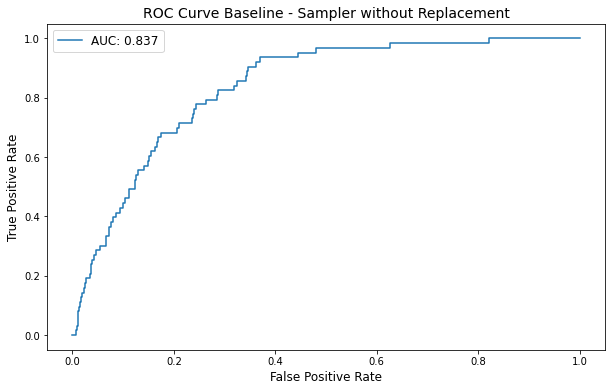

In [6]:
plot_roc(baseline_noreplace_roc_curve_stat, title="ROC Curve Baseline - Sampler without Replacement")

### Baseline - 10 epochs, No data augmentation, no oversampling 

In [4]:
# Run setup
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0)

# Instantiate Dataloaders
# Note: sampling ratio set at 2% as per original proportion
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, 
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10

In [13]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [188]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch10_b32_tb0_os0= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Epoch10_b32_tb0_os0")


 epoch: 0, train loss: 0.118741, val loss: 0.096522, train acc: 0.9768, val acc: 0.9799, val roc:0.6890



 epoch: 1, train loss: 0.095318, val loss: 0.086537, train acc: 0.9782, val acc: 0.9821, val roc:0.7340



 epoch: 2, train loss: 0.084967, val loss: 0.087104, train acc: 0.9799, val acc: 0.9808, val roc:0.8041



 epoch: 3, train loss: 0.082139, val loss: 0.080008, train acc: 0.9808, val acc: 0.9817, val roc:0.8077



 epoch: 4, train loss: 0.083549, val loss: 0.078664, train acc: 0.9801, val acc: 0.9827, val roc:0.8085



 epoch: 5, train loss: 0.075703, val loss: 0.078516, train acc: 0.9816, val acc: 0.9827, val roc:0.8101



 epoch: 6, train loss: 0.076020, val loss: 0.078817, train acc: 0.9811, val acc: 0.9830, val roc:0.7945



 epoch: 7, train loss: 0.076612, val loss: 0.077347, train acc: 0.9814, val acc: 0.9828, val roc:0.8054



 epoch: 8, train loss: 0.078283, val loss: 0.077726, train acc: 0.9808, val acc: 0.9827, val roc:0.8149



 epoch: 9, train loss: 0.076499, val loss: 0.079179, train acc: 0.9801, val acc: 0.9813, val roc:0.8300
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Epoch10_b32_tb0_os0.pth.tar saved.
Training Finished
Training and validation time: 4489.361767053604 seconds


In [7]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Epoch10_b32_tb0_os0.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [8]:
baseline_test_results, baseline_roc_curve_stat= test(model, test_loader=test_loader, device=device)

In [9]:
baseline_test_results

{'test_accuracy': 0.9788670384502495,
 'test_roc_score': 0.821523505734032,
 'CM': array([[3334,   10],
        [  62,    1]], dtype=int64)}

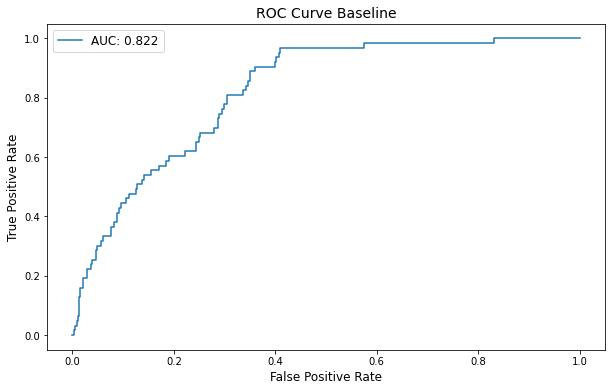

In [10]:
plot_roc(baseline_roc_curve_stat, title="ROC Curve Baseline")

### Baseline - 15 epochs, No data augmentation, no oversampling 

In [31]:
# Run setup
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0)

# Instantiate Dataloaders
# Note: sampling ratio set at 2% as per original proportion
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, 
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [32]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [33]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb0_os0= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Epoch15_b32_tb0_os0")


 epoch: 0, train loss: 0.119282, val loss: 0.095053, train acc: 0.9761, val acc: 0.9798, val roc:0.7002



 epoch: 1, train loss: 0.094897, val loss: 0.085801, train acc: 0.9778, val acc: 0.9822, val roc:0.7499



 epoch: 2, train loss: 0.085259, val loss: 0.087458, train acc: 0.9800, val acc: 0.9811, val roc:0.8053



 epoch: 3, train loss: 0.082225, val loss: 0.084602, train acc: 0.9802, val acc: 0.9796, val roc:0.8061



 epoch: 4, train loss: 0.083260, val loss: 0.079307, train acc: 0.9800, val acc: 0.9824, val roc:0.7985



 epoch: 5, train loss: 0.075797, val loss: 0.078363, train acc: 0.9815, val acc: 0.9824, val roc:0.8136



 epoch: 6, train loss: 0.076854, val loss: 0.078232, train acc: 0.9809, val acc: 0.9830, val roc:0.8004



 epoch: 7, train loss: 0.078180, val loss: 0.077313, train acc: 0.9806, val acc: 0.9828, val roc:0.8103



 epoch: 8, train loss: 0.078909, val loss: 0.077945, train acc: 0.9808, val acc: 0.9828, val roc:0.8199



 epoch: 9, train loss: 0.076866, val loss: 0.078587, train acc: 0.9797, val acc: 0.9810, val roc:0.8280



 epoch: 10, train loss: 0.072360, val loss: 0.076485, train acc: 0.9818, val acc: 0.9828, val roc:0.8192



 epoch: 11, train loss: 0.075585, val loss: 0.077608, train acc: 0.9807, val acc: 0.9821, val roc:0.8219



 epoch: 12, train loss: 0.076714, val loss: 0.077350, train acc: 0.9806, val acc: 0.9830, val roc:0.8078



 epoch: 13, train loss: 0.076133, val loss: 0.078620, train acc: 0.9794, val acc: 0.9828, val roc:0.8039



 epoch: 14, train loss: 0.074377, val loss: 0.076565, train acc: 0.9800, val acc: 0.9828, val roc:0.8223
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Epoch15_b32_tb0_os0.pth.tar saved.
Training Finished
Training and validation time: 6569.054447650909 seconds


In [11]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Epoch15_b32_tb0_os0.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [12]:
baseline_e15_test_results, baseline_e15_roc_curve_stat= test(model, test_loader=test_loader, device=device)

In [13]:
baseline_e15_test_results

{'test_accuracy': 0.9812151452891107,
 'test_roc_score': 0.8172467152730309,
 'CM': array([[3343,    1],
        [  63,    0]], dtype=int64)}

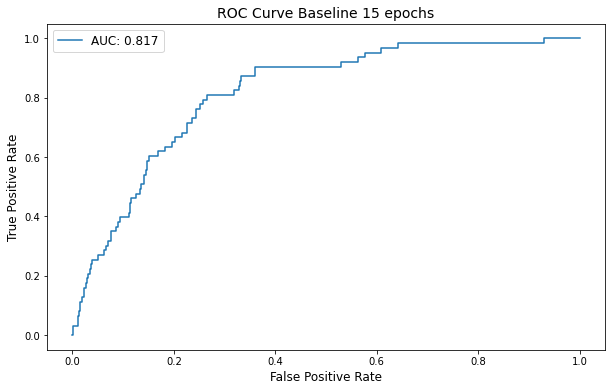

In [14]:
plot_roc(baseline_e15_roc_curve_stat, title="ROC Curve Baseline 15 epochs")

### Baseline - 15 epochs, No data augmentation, no oversampling, single fc classifier 

In [4]:
# Run setup
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0)

# Instantiate Dataloaders
# Note: sampling ratio set at 2% as per original proportion
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, 
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [4]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNetSingle(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [5]:
# Run training/validation Melanoma EfficientNet

MelanomaS_Base_Epoch15_b32_tb0_os0= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="MelanomaS_Epoch15_b32_tb0_os0")


 epoch: 0, train loss: 0.225445, val loss: 0.177866, train acc: 0.9619, val acc: 0.9595, val roc:0.5012



 epoch: 1, train loss: 0.148745, val loss: 0.149917, train acc: 0.9723, val acc: 0.9676, val roc:0.5344



 epoch: 2, train loss: 0.128154, val loss: 0.139862, train acc: 0.9754, val acc: 0.9705, val roc:0.5611



 epoch: 3, train loss: 0.123793, val loss: 0.130232, train acc: 0.9773, val acc: 0.9737, val roc:0.5877



 epoch: 4, train loss: 0.118570, val loss: 0.123451, train acc: 0.9781, val acc: 0.9754, val roc:0.6023



 epoch: 5, train loss: 0.109066, val loss: 0.117239, train acc: 0.9793, val acc: 0.9766, val roc:0.6151



 epoch: 6, train loss: 0.109179, val loss: 0.115655, train acc: 0.9790, val acc: 0.9775, val roc:0.6275



 epoch: 7, train loss: 0.107864, val loss: 0.113418, train acc: 0.9787, val acc: 0.9776, val roc:0.6438



 epoch: 8, train loss: 0.109121, val loss: 0.110338, train acc: 0.9795, val acc: 0.9782, val roc:0.6530



 epoch: 9, train loss: 0.104457, val loss: 0.108863, train acc: 0.9789, val acc: 0.9786, val roc:0.6662



 epoch: 10, train loss: 0.102129, val loss: 0.105520, train acc: 0.9804, val acc: 0.9793, val roc:0.6727



 epoch: 11, train loss: 0.098375, val loss: 0.104170, train acc: 0.9796, val acc: 0.9792, val roc:0.6796



 epoch: 12, train loss: 0.099567, val loss: 0.103095, train acc: 0.9796, val acc: 0.9796, val roc:0.6826



 epoch: 13, train loss: 0.099853, val loss: 0.101723, train acc: 0.9789, val acc: 0.9795, val roc:0.6877



 epoch: 14, train loss: 0.097651, val loss: 0.100158, train acc: 0.9795, val acc: 0.9796, val roc:0.6916
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_MelanomaS_Epoch15_b32_tb0_os0.pth.tar saved.
Training Finished
Training and validation time: 6489.342362165451 seconds


In [15]:
# Test run
Melanoma_model= MelanomaEfficientNetSingle(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_MelanomaS_Epoch15_b32_tb0_os0.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNetSingle(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padd

In [16]:
baseline_fcS_e15_test_results, baseline_fcS_e15_roc_curve_stat= test(model, test_loader=test_loader, device=device)

In [17]:
baseline_fcS_e15_test_results

{'test_accuracy': 0.9771059583211036,
 'test_roc_score': 0.6571305156831473,
 'CM': array([[3328,   16],
        [  62,    1]], dtype=int64)}

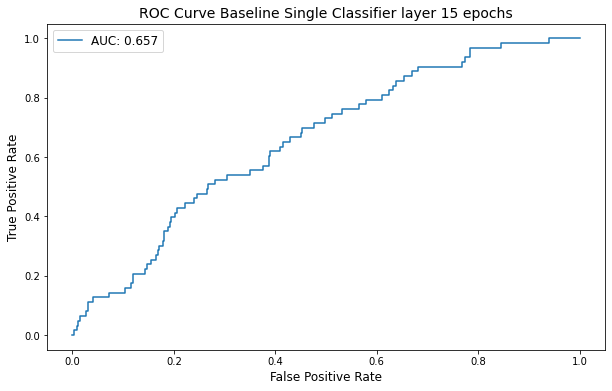

In [18]:
plot_roc(baseline_fcS_e15_roc_curve_stat, title="ROC Curve Baseline Single Classifier layer 15 epochs")

In [20]:
# Comparing baseline models training and validation curves

#Baseline no replace (15epochs)
Baseline_noreplace=load_results("TrainedEffNetcheckpoint_Base_Epoch15_b32_tb0_os0_lr4_no.pth.tar")

#Baseline 10 epochs
Baseline_10e=load_results("TrainedEffNetcheckpoint_Epoch10_b32_tb0_os0.pth.tar")

#Baseline 15 epochs
Baseline_15e=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb0_os0.pth.tar")

#Baseline Single Classifier
Baseline_Single_Classifier=load_results("TrainedEffNetcheckpoint_MelanomaS_Epoch15_b32_tb0_os0.pth.tar")


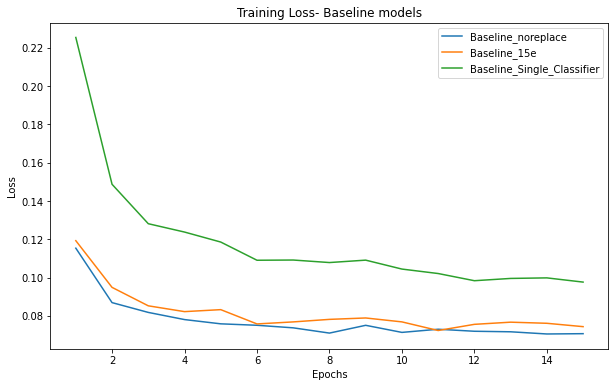

In [46]:
# Compare training curves between models
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_noreplace['train_loss']) + 1)
plt.plot(epoch_count, (Baseline_noreplace['train_loss']), label='Baseline_noreplace')
plt.plot(epoch_count, (Baseline_15e['train_loss']), label='Baseline_15e')
plt.plot(epoch_count, (Baseline_Single_Classifier['train_loss']), label='Baseline_Single_Classifier')
plt.title("Training Loss- Baseline models" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

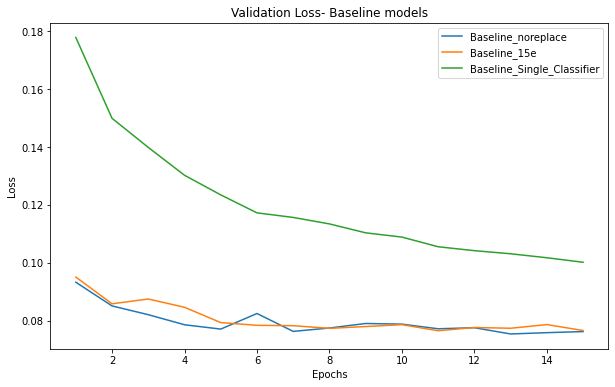

In [47]:
# Compare val curves between models
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_noreplace['val_loss']) + 1)
plt.plot(epoch_count, (Baseline_noreplace['val_loss']), label='Baseline_noreplace')
plt.plot(epoch_count, (Baseline_15e['val_loss']), label='Baseline_15e')
plt.plot(epoch_count, (Baseline_Single_Classifier['val_loss']), label='Baseline_Single_Classifier')
plt.title("Validation Loss- Baseline models" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

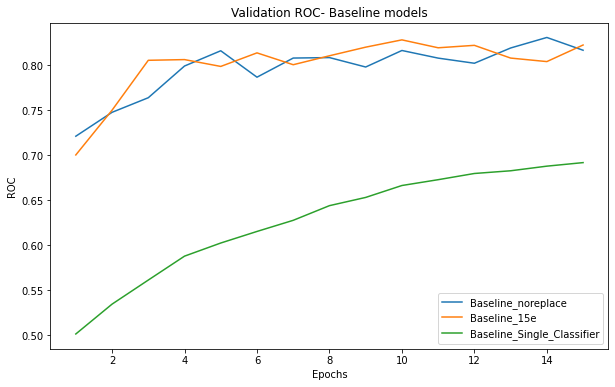

In [48]:
# Compare ROC curves between models
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_noreplace['val_roc']) + 1)
plt.plot(epoch_count, (Baseline_noreplace['val_roc']), label='Baseline_noreplace')
plt.plot(epoch_count, (Baseline_15e['val_roc']), label='Baseline_15e')
plt.plot(epoch_count, (Baseline_Single_Classifier['val_roc']), label='Baseline_Single_Classifier')
plt.title("Validation ROC- Baseline models" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

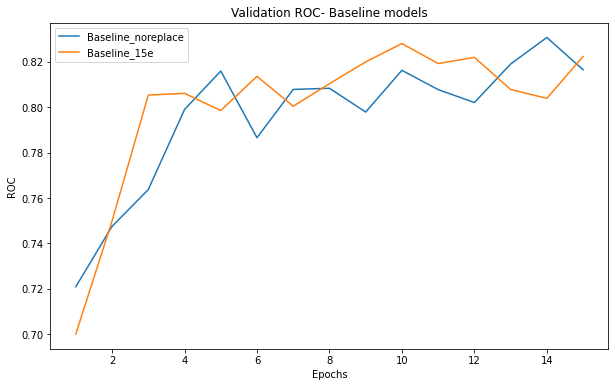

In [21]:
# Compare ROC curves between models - Baseline replacement disabled vs Baseline ONLY
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_noreplace['val_roc']) + 1)
plt.plot(epoch_count, (Baseline_noreplace['val_roc']), label='Baseline_noreplace')
plt.plot(epoch_count, (Baseline_15e['val_roc']), label='Baseline_15e')
plt.title("Validation ROC- Baseline models" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

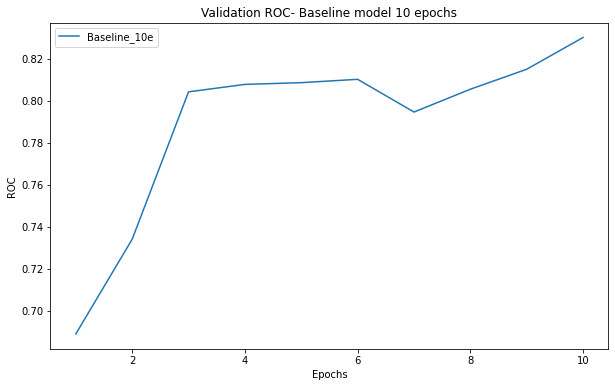

In [50]:
# 10 epoch Validation ROC - Baseline model
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_10e['val_roc']) + 1)
plt.plot(epoch_count, (Baseline_10e['val_roc']), label='Baseline_10e')
plt.title("Validation ROC- Baseline model 10 epochs" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

In [38]:
# ROC Test results comparison
Baseline_data= {'baseline_noreplace':[baseline_test_results_noreplace['test_roc_score']],'baseline_10e':[ baseline_test_results['test_roc_score']],
               'baseline_15e':[baseline_e15_test_results['test_roc_score']], 'baseline_Single_Classifier':[baseline_fcS_e15_test_results['test_roc_score']] }
Baseline_results= pd.DataFrame(Baseline_data)
Baseline_results

baseline_noreplace  baseline_10e  baseline_15e  baseline_Single_Classifier
0             0.83705      0.821524      0.817247                    0.657131

Conclusion:
* Single classifier model does not perform as well as multi-layer classifier. 
* Validation ROC similar for 15 epoch baseline model with and without sampler replacement enabled
* Despite test results showing improvement for sampler replacement disabled 
* Batch sampling with replacement and batch sampling without replacement show no difference during training, hence will continue with replacement because the PyTorch weightedRandomSampler that we will use for oversampling will rely on replacement.


### Investigating training augmentation probability

### Modified - 10 epochs, 80% probability of augmentation and oversampling 20% 

In [9]:
# 80% augmentation used to preserve training on some original images and 20% oversampling to 
# maintain differences in class balance
# Run setup
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.8,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10

In [192]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() # or BCELoss(need to apply additional sigmoid) or Focal Loss
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [193]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch10_b32_tb08_os2= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Epoch10_b32_tb08_os2")


 epoch: 0, train loss: 0.374332, val loss: 0.194372, train acc: 0.8436, val acc: 0.9465, val roc:0.8157



 epoch: 1, train loss: 0.347139, val loss: 0.169240, train acc: 0.8479, val acc: 0.9605, val roc:0.8200



 epoch: 2, train loss: 0.338147, val loss: 0.169794, train acc: 0.8500, val acc: 0.9591, val roc:0.8333



 epoch: 3, train loss: 0.339015, val loss: 0.184630, train acc: 0.8490, val acc: 0.9510, val roc:0.8267



 epoch: 4, train loss: 0.338761, val loss: 0.158372, train acc: 0.8495, val acc: 0.9629, val roc:0.8354



 epoch: 5, train loss: 0.331563, val loss: 0.180763, train acc: 0.8536, val acc: 0.9553, val roc:0.8407



 epoch: 6, train loss: 0.336813, val loss: 0.156857, train acc: 0.8497, val acc: 0.9611, val roc:0.8330



 epoch: 7, train loss: 0.332714, val loss: 0.166857, train acc: 0.8522, val acc: 0.9659, val roc:0.8373



 epoch: 8, train loss: 0.342112, val loss: 0.170473, train acc: 0.8493, val acc: 0.9617, val roc:0.8321



 epoch: 9, train loss: 0.320205, val loss: 0.138214, train acc: 0.8584, val acc: 0.9679, val roc:0.8409
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Epoch10_b32_tb08_os2.pth.tar saved.
Training Finished
Training and validation time: 6889.999991416931 seconds


In [22]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Epoch10_b32_tb08_os2.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [23]:
tb08_os2_test_results, tb08_os2_roc_curve_stat= test(model, test_loader=test_loader, device=device)

In [24]:
tb08_os2_test_results

{'test_accuracy': 0.9662459641913707,
 'test_roc_score': 0.8164967342598921,
 'CM': array([[3283,   61],
        [  54,    9]], dtype=int64)}

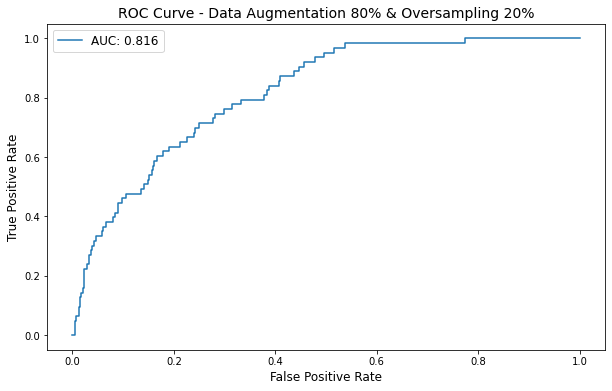

In [25]:
plot_roc(tb08_os2_roc_curve_stat, title="ROC Curve - Data Augmentation 80% & Oversampling 20%")

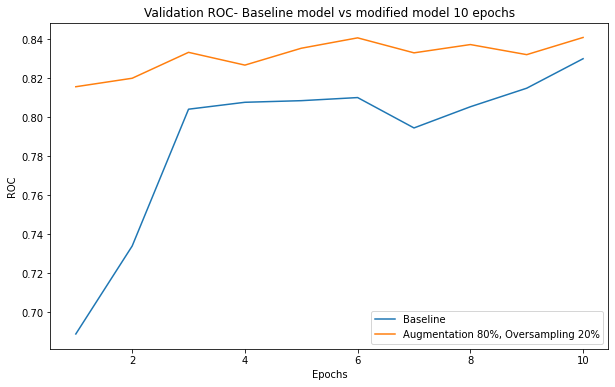

In [51]:
# Compare 10 epochs data augmentation + over sampling with 10 epoch run in baseline model

#Baseline 10 epochs
Baseline_10e=load_results("TrainedEffNetcheckpoint_Epoch10_b32_tb0_os0.pth.tar")

#Modified Augmentation probability 80% and 20% oversampling
Aug_os_10e=load_results("TrainedEffNetcheckpoint_Epoch10_b32_tb08_os2.pth.tar")

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_10e['val_roc']) + 1)
plt.plot(epoch_count, (Baseline_10e['val_roc']), label='Baseline')
plt.plot(epoch_count, (Aug_os_10e['val_roc']), label='Augmentation 80%, Oversampling 20%')
plt.title("Validation ROC- Baseline model vs modified model 10 epochs" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()


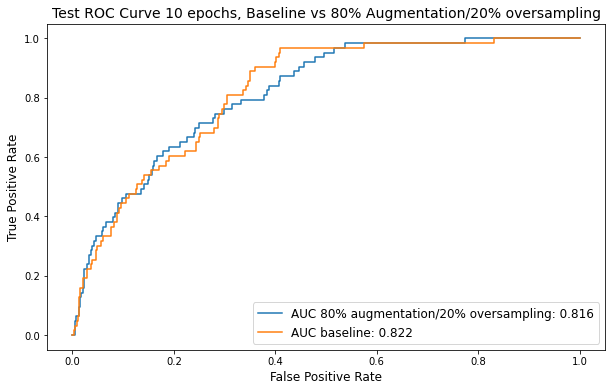

In [31]:
# Comparison of baseline and modified model ROC Test curves - 10 epochs
fig=plt.figure(figsize=(10,6))
AUC_baseline= "{:.3f}".format(baseline_roc_curve_stat['AUC'])
AUC_modified="{:.3f}".format(tb08_os2_roc_curve_stat['AUC'])
score_baseline= "AUC baseline: " + str(AUC_baseline)
score_modified="AUC 80% augmentation/20% oversampling: " + str(AUC_modified)
plt.plot(tb08_os2_roc_curve_stat['fpr'],tb08_os2_roc_curve_stat['tpr'], label=score_modified)
plt.plot(baseline_roc_curve_stat['fpr'],baseline_roc_curve_stat['tpr'], label=score_baseline)
plt.title("Test ROC Curve 10 epochs, Baseline vs 80% Augmentation/20% oversampling", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

### Modified - 15 epochs, 80% probability of augmentation and oversampling 20% 

In [24]:
# 80% augmentation used to preserve training on some original images and 20% oversampling to 
# maintain differences in class balance
# Run setup
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.8,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [25]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() # or BCELoss(need to apply additional sigmoid) or Focal Loss
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [26]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb08_os2= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Epoch15_b32_tb08_os2")


 epoch: 0, train loss: 0.375480, val loss: 0.214189, train acc: 0.8423, val acc: 0.9370, val roc:0.8221



 epoch: 1, train loss: 0.350429, val loss: 0.174403, train acc: 0.8465, val acc: 0.9580, val roc:0.8231



 epoch: 2, train loss: 0.341264, val loss: 0.164804, train acc: 0.8489, val acc: 0.9600, val roc:0.8341



 epoch: 3, train loss: 0.343034, val loss: 0.179657, train acc: 0.8436, val acc: 0.9566, val roc:0.8251



 epoch: 4, train loss: 0.342629, val loss: 0.160035, train acc: 0.8450, val acc: 0.9626, val roc:0.8327



 epoch: 5, train loss: 0.332902, val loss: 0.186956, train acc: 0.8547, val acc: 0.9518, val roc:0.8415



 epoch: 6, train loss: 0.338200, val loss: 0.163804, train acc: 0.8500, val acc: 0.9638, val roc:0.8392



 epoch: 7, train loss: 0.335250, val loss: 0.167996, train acc: 0.8528, val acc: 0.9643, val roc:0.8380



 epoch: 8, train loss: 0.346479, val loss: 0.163912, train acc: 0.8452, val acc: 0.9623, val roc:0.8347



 epoch: 9, train loss: 0.327949, val loss: 0.139504, train acc: 0.8522, val acc: 0.9688, val roc:0.8404



 epoch: 10, train loss: 0.328752, val loss: 0.156975, train acc: 0.8536, val acc: 0.9608, val roc:0.8456



 epoch: 11, train loss: 0.330768, val loss: 0.148640, train acc: 0.8517, val acc: 0.9659, val roc:0.8382



 epoch: 12, train loss: 0.335542, val loss: 0.170817, train acc: 0.8484, val acc: 0.9536, val roc:0.8401



 epoch: 13, train loss: 0.335561, val loss: 0.137472, train acc: 0.8470, val acc: 0.9690, val roc:0.8419



 epoch: 14, train loss: 0.328928, val loss: 0.147927, train acc: 0.8544, val acc: 0.9670, val roc:0.8344
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Epoch15_b32_tb08_os2.pth.tar saved.
Training Finished
Training and validation time: 10540.163058042526 seconds


In [26]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Epoch15_b32_tb08_os2.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [27]:
e15_tb08_os2_test_results, e15_tb08_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [28]:
e15_tb08_os2_test_results

{'test_accuracy': 0.9653654241267978,
 'test_roc_score': 0.8254727728411939,
 'CM': array([[3277,   67],
        [  51,   12]], dtype=int64)}

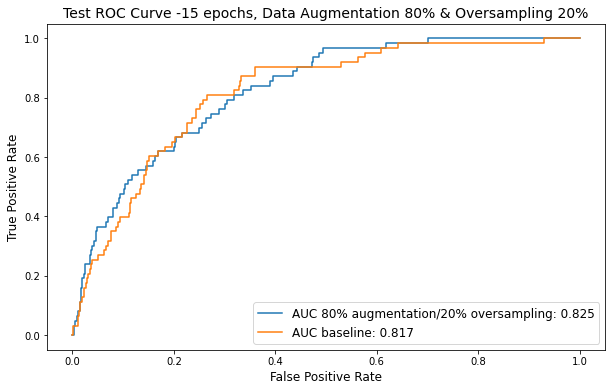

In [32]:

# Comparison of baseline and modified model ROC Test curves - 15 epochs
fig=plt.figure(figsize=(10,6))
AUC_baseline= "{:.3f}".format(baseline_e15_roc_curve_stat['AUC'])
AUC_modified="{:.3f}".format(e15_tb08_os2_roc_curve_stat['AUC'])
score_baseline= "AUC baseline: " + str(AUC_baseline)
score_modified="AUC 80% augmentation/20% oversampling: " + str(AUC_modified)
plt.plot(e15_tb08_os2_roc_curve_stat['fpr'],e15_tb08_os2_roc_curve_stat['tpr'], label=score_modified)
plt.plot(baseline_e15_roc_curve_stat['fpr'],baseline_e15_roc_curve_stat['tpr'], label=score_baseline)
plt.title("Test ROC Curve -15 epochs, Data Augmentation 80% & Oversampling 20%", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

### Modified - 15 epochs, 80% probability of augmentation and oversampling 20% - single fc classifier layer

In [6]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.8,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [7]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNetSingle(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() # or BCELoss(need to apply additional sigmoid) or Focal Loss
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [8]:
# Run training/validation Melanoma EfficientNet

MelanomaS_Base_Epoch15_b32_tb08_os2= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="MelanomaS_Epoch15_b32_tb08_os2")


 epoch: 0, train loss: 0.477148, val loss: 0.287798, train acc: 0.8241, val acc: 0.9603, val roc:0.6738



 epoch: 1, train loss: 0.419287, val loss: 0.271494, train acc: 0.8286, val acc: 0.9462, val roc:0.7480



 epoch: 2, train loss: 0.400218, val loss: 0.259308, train acc: 0.8313, val acc: 0.9419, val roc:0.7727



 epoch: 3, train loss: 0.394122, val loss: 0.245913, train acc: 0.8307, val acc: 0.9430, val roc:0.7800



 epoch: 4, train loss: 0.384942, val loss: 0.243228, train acc: 0.8313, val acc: 0.9399, val roc:0.7903



 epoch: 5, train loss: 0.371990, val loss: 0.237401, train acc: 0.8397, val acc: 0.9411, val roc:0.7968



 epoch: 6, train loss: 0.372469, val loss: 0.230908, train acc: 0.8405, val acc: 0.9439, val roc:0.7966



 epoch: 7, train loss: 0.369058, val loss: 0.229713, train acc: 0.8424, val acc: 0.9460, val roc:0.8004



 epoch: 8, train loss: 0.377815, val loss: 0.235382, train acc: 0.8346, val acc: 0.9437, val roc:0.8072



 epoch: 9, train loss: 0.360559, val loss: 0.225228, train acc: 0.8429, val acc: 0.9455, val roc:0.8078



 epoch: 10, train loss: 0.355861, val loss: 0.222945, train acc: 0.8447, val acc: 0.9445, val roc:0.8131



 epoch: 11, train loss: 0.359782, val loss: 0.220535, train acc: 0.8441, val acc: 0.9460, val roc:0.8144



 epoch: 12, train loss: 0.360406, val loss: 0.223237, train acc: 0.8407, val acc: 0.9434, val roc:0.8153



 epoch: 13, train loss: 0.358175, val loss: 0.206742, train acc: 0.8411, val acc: 0.9521, val roc:0.8165



 epoch: 14, train loss: 0.351201, val loss: 0.200019, train acc: 0.8452, val acc: 0.9548, val roc:0.8143
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_MelanomaS_Epoch15_b32_tb08_os2.pth.tar saved.
Training Finished
Training and validation time: 10339.98806977272 seconds


In [34]:
# Test run
Melanoma_model= MelanomaEfficientNetSingle(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_MelanomaS_Epoch15_b32_tb08_os2.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNetSingle(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padd

In [35]:
FcS_e15_tb08_os2_test_results, FcS_e15_tb08_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [37]:
FcS_e15_tb08_os2_test_results

{'test_accuracy': 0.9457000293513355,
 'test_roc_score': 0.7851874003189792,
 'CM': array([[3210,  134],
        [  51,   12]], dtype=int64)}

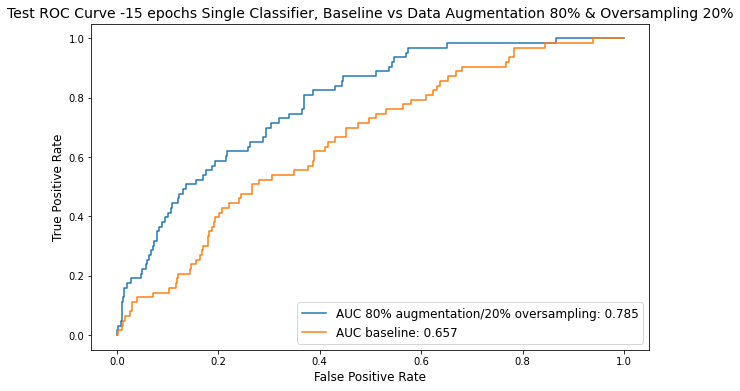

In [39]:
# Comparison of baseline and modified single classifier ROC Test curves - 15 epochs
fig=plt.figure(figsize=(10,6))
AUC_baseline= "{:.3f}".format(baseline_fcS_e15_roc_curve_stat['AUC'])
AUC_modified="{:.3f}".format(FcS_e15_tb08_os2_roc_curve_stat['AUC'])
score_baseline= "AUC baseline: " + str(AUC_baseline)
score_modified="AUC 80% augmentation/20% oversampling: " + str(AUC_modified)
plt.plot(FcS_e15_tb08_os2_roc_curve_stat['fpr'],FcS_e15_tb08_os2_roc_curve_stat['tpr'], label=score_modified)
plt.plot(baseline_fcS_e15_roc_curve_stat['fpr'],baseline_fcS_e15_roc_curve_stat['tpr'], label=score_baseline)
plt.title("Test ROC Curve -15 epochs Single Classifier, Baseline vs Data Augmentation 80% & Oversampling 20%", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

### Compare baseline 15 epochs, no augmentation/sampling vs augmentation/sampling

In [65]:
#Load baselines results
Baseline_15e=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb0_os0.pth.tar")

#Load augmentation/oversampling results
Modified_80tp_20os=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb08_os2.pth.tar")

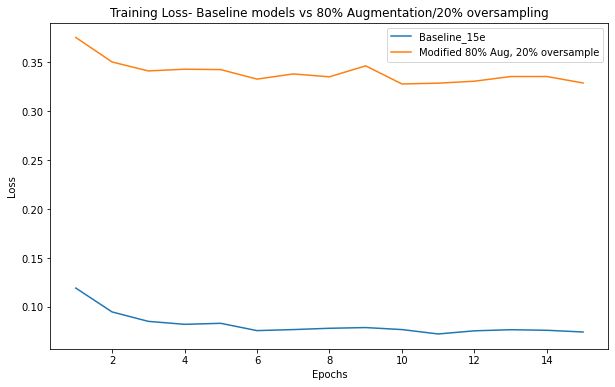

In [66]:
# Compare training curves between models
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_15e['train_loss']) + 1)
plt.plot(epoch_count, (Baseline_15e['train_loss']), label='Baseline_15e')
plt.plot(epoch_count, (Modified_80tp_20os['train_loss']), label='Modified 80% Aug, 20% oversample')
plt.title("Training Loss- Baseline models vs 80% Augmentation/20% oversampling" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

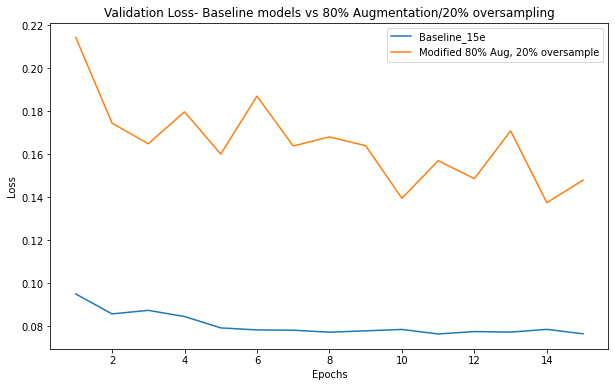

In [69]:
# Compare val loss curves between models
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_15e['val_loss']) + 1)
plt.plot(epoch_count, (Baseline_15e['val_loss']), label='Baseline_15e')
plt.plot(epoch_count, (Modified_80tp_20os['val_loss']), label='Modified 80% Aug, 20% oversample')
plt.title("Validation Loss- Baseline models vs 80% Augmentation/20% oversampling" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

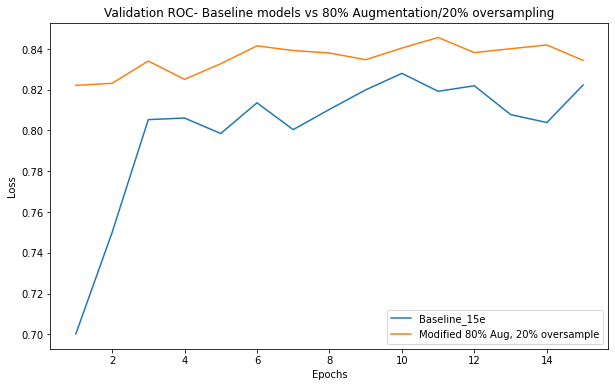

In [70]:
# Compare ROC curves between models

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(Baseline_15e['val_roc']) + 1)
plt.plot(epoch_count, (Baseline_15e['val_roc']), label='Baseline_15e')
plt.plot(epoch_count, (Modified_80tp_20os['val_roc']), label='Modified 80% Aug, 20% oversample')
plt.title("Validation ROC- Baseline models vs 80% Augmentation/20% oversampling" , fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

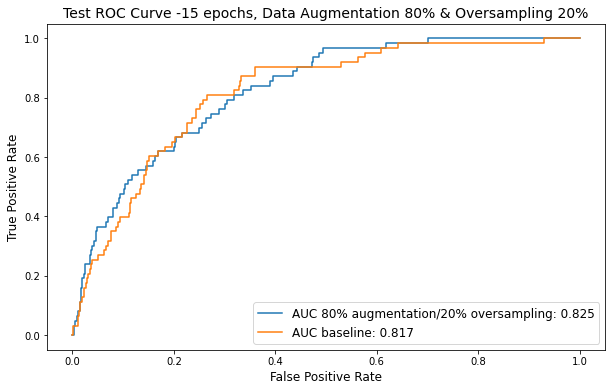

In [40]:
# Comparison of baseline and modified model ROC Test curves - 15 epochs
fig=plt.figure(figsize=(10,6))
AUC_baseline= "{:.3f}".format(baseline_e15_roc_curve_stat['AUC'])
AUC_modified="{:.3f}".format(e15_tb08_os2_roc_curve_stat['AUC'])
score_baseline= "AUC baseline: " + str(AUC_baseline)
score_modified="AUC 80% augmentation/20% oversampling: " + str(AUC_modified)
plt.plot(e15_tb08_os2_roc_curve_stat['fpr'],e15_tb08_os2_roc_curve_stat['tpr'], label=score_modified)
plt.plot(baseline_e15_roc_curve_stat['fpr'],baseline_e15_roc_curve_stat['tpr'], label=score_baseline)
plt.title("Test ROC Curve -15 epochs, Data Augmentation 80% & Oversampling 20%", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

Conclusion:
* Difference in training/validation loss between Baseline and augmentation models
* Slight improvement in test ROC at 15 epochs between Baseline and augmentation model
* Augmentation model converges faster and appears more stable over epochs

### Investigate epochs
### Modified - 25 epochs, 80% probability of augmentation and oversampling 20% 

In [23]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.8,dataseed=0)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, test_set=test_set, 
                                                          batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 25

In [24]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [25]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch25_b32_tb05_os2_lr4= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch25_b32_tb08_os2_lr4")


 epoch: 0, train loss: 0.375480, val loss: 0.214189, train acc: 0.8423, val acc: 0.9370, val roc:0.8221



 epoch: 1, train loss: 0.350429, val loss: 0.174403, train acc: 0.8465, val acc: 0.9580, val roc:0.8231



 epoch: 2, train loss: 0.341264, val loss: 0.164804, train acc: 0.8489, val acc: 0.9600, val roc:0.8341



 epoch: 3, train loss: 0.343034, val loss: 0.179657, train acc: 0.8436, val acc: 0.9566, val roc:0.8251



 epoch: 4, train loss: 0.342629, val loss: 0.160035, train acc: 0.8450, val acc: 0.9626, val roc:0.8327



 epoch: 5, train loss: 0.332902, val loss: 0.186956, train acc: 0.8547, val acc: 0.9518, val roc:0.8415



 epoch: 6, train loss: 0.338200, val loss: 0.163804, train acc: 0.8500, val acc: 0.9638, val roc:0.8392



 epoch: 7, train loss: 0.335250, val loss: 0.167996, train acc: 0.8528, val acc: 0.9643, val roc:0.8380



 epoch: 8, train loss: 0.346479, val loss: 0.163912, train acc: 0.8452, val acc: 0.9623, val roc:0.8347



 epoch: 9, train loss: 0.327949, val loss: 0.139504, train acc: 0.8522, val acc: 0.9688, val roc:0.8404



 epoch: 10, train loss: 0.328752, val loss: 0.156975, train acc: 0.8536, val acc: 0.9608, val roc:0.8456



 epoch: 11, train loss: 0.330768, val loss: 0.148640, train acc: 0.8517, val acc: 0.9659, val roc:0.8382



 epoch: 12, train loss: 0.335542, val loss: 0.170817, train acc: 0.8484, val acc: 0.9536, val roc:0.8401



 epoch: 13, train loss: 0.335561, val loss: 0.137472, train acc: 0.8470, val acc: 0.9690, val roc:0.8419



 epoch: 14, train loss: 0.328928, val loss: 0.147927, train acc: 0.8544, val acc: 0.9670, val roc:0.8344



 epoch: 15, train loss: 0.336410, val loss: 0.179390, train acc: 0.8483, val acc: 0.9480, val roc:0.8396



 epoch: 16, train loss: 0.327341, val loss: 0.157986, train acc: 0.8530, val acc: 0.9652, val roc:0.8429



 epoch: 17, train loss: 0.332303, val loss: 0.169459, train acc: 0.8525, val acc: 0.9547, val roc:0.8420



 epoch: 18, train loss: 0.326588, val loss: 0.150082, train acc: 0.8565, val acc: 0.9673, val roc:0.8437



 epoch: 19, train loss: 0.331889, val loss: 0.133811, train acc: 0.8490, val acc: 0.9714, val roc:0.8393



 epoch: 20, train loss: 0.330564, val loss: 0.157183, train acc: 0.8500, val acc: 0.9611, val roc:0.8426



 epoch: 21, train loss: 0.331159, val loss: 0.183783, train acc: 0.8525, val acc: 0.9516, val roc:0.8454



 epoch: 22, train loss: 0.337262, val loss: 0.150240, train acc: 0.8480, val acc: 0.9684, val roc:0.8446



 epoch: 23, train loss: 0.321625, val loss: 0.142419, train acc: 0.8575, val acc: 0.9735, val roc:0.8400



 epoch: 24, train loss: 0.331175, val loss: 0.174334, train acc: 0.8506, val acc: 0.9574, val roc:0.8436
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch25_b32_tb08_os2_lr4.pth.tar saved.
Training Finished
Training and validation time: 17853.228620529175 seconds


In [71]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Base_Epoch25_b32_tb08_os2_lr4.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [72]:
e25_tb08_os2_test_results, e25_tb08_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [44]:
e25_tb08_os2_test_results

{'test_accuracy': 0.9562665101262108,
 'test_roc_score': 0.8252354370775422,
 'CM': array([[3246,   98],
        [  51,   12]], dtype=int64)}

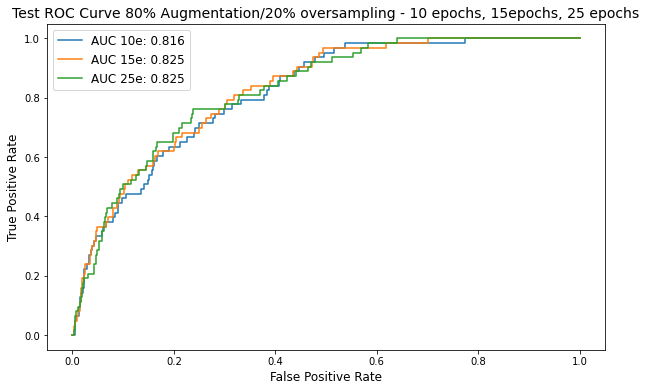

In [75]:
# Compare Test ROC Curve for 25 epochs vs 15 epochs vs 10 epochs
fig=plt.figure(figsize=(10,6))
AUC_10e= "{:.3f}".format(tb08_os2_roc_curve_stat['AUC'])
AUC_15e= "{:.3f}".format(e15_tb08_os2_roc_curve_stat['AUC'])
AUC_25e="{:.3f}".format(e25_tb08_os2_roc_curve_stat['AUC'])
score_10e= "AUC 10e: " + str(AUC_10e)
score_15e= "AUC 15e: " + str(AUC_15e)
score_25e="AUC 25e: " + str(AUC_25e)
plt.plot(tb08_os2_roc_curve_stat['fpr'],tb08_os2_roc_curve_stat['tpr'], label=score_10e)
plt.plot(e15_tb08_os2_roc_curve_stat['fpr'],e15_tb08_os2_roc_curve_stat['tpr'], label=score_15e)
plt.plot(e25_tb08_os2_roc_curve_stat['fpr'],e25_tb08_os2_roc_curve_stat['tpr'], label=score_25e)
plt.title("Test ROC Curve 80% Augmentation/20% oversampling - 10 epochs, 15epochs, 25 epochs", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()


#### Training loss and Val loss curves for 25 epoch run

In [156]:
e25_tb08_os2_train_results=load_results("TrainedEffNetcheckpoint_Base_Epoch25_b32_tb08_os2_lr4.pth.tar")

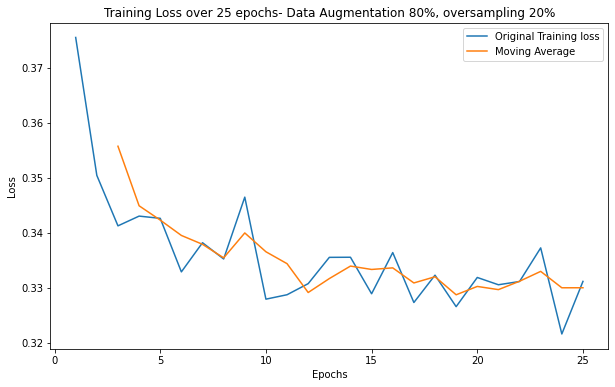

In [157]:
# Training Loss for 25 epoch run - plotted against moving average to visualise trend as the loss is volatile.

# moving average over 3 data points.
w=3
ma_train_loss = moving_average(e25_tb08_os2_train_results['train_loss'],w)

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e25_tb08_os2_train_results['train_loss']) + 1)
plt.plot(epoch_count, (e25_tb08_os2_train_results['train_loss']), label='Original Training loss')
ma_e_count = range(w, len(ma_train_loss)+w)
plt.plot(ma_e_count, ma_train_loss, label='Moving Average')

plt.title("Training Loss over 25 epochs- Data Augmentation 80%, oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

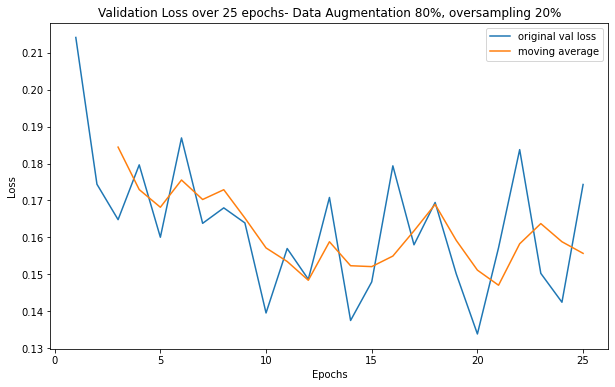

In [158]:
# Validation Loss for 25 epoch run - plotted against moving average to visualise trend as the loss is volatile.

# moving average over 3 data points.
fig=plt.figure(figsize=(10,6))
w=3
ma_val_loss = moving_average(e25_tb08_os2_train_results['val_loss'],w)
epoch_count = range(1, len(e25_tb08_os2_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e25_tb08_os2_train_results['val_loss']), label='original val loss')
ma_e_count = range(w, len(ma_val_loss)+w)
plt.plot(ma_e_count, ma_val_loss, label='moving average')
plt.title("Validation Loss over 25 epochs- Data Augmentation 80%, oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

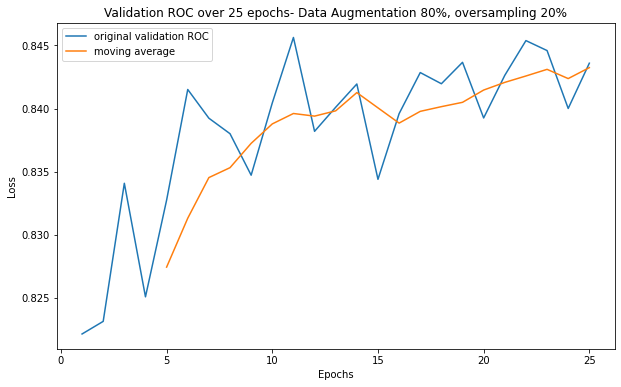

In [159]:
# validation ROC curve for 25 epoch run, learning rate 1e-4
fig=plt.figure(figsize=(10,6))
# moving average over 5 datapoints
w=5
ma_val_roc = moving_average(e25_tb08_os2_train_results['val_roc'],w)

epoch_count = range(1, len(e25_tb08_os2_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e25_tb08_os2_train_results['val_roc']), label='original validation ROC')

ma_e_count = range(w, len(ma_val_roc)+w)
plt.plot(ma_e_count, ma_val_roc, label='moving average')

plt.title("Validation ROC over 25 epochs- Data Augmentation 80%, oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

Conclusions: 
* Training loss and validation loss appear to converge before 25 epochs, suggesting 15 epochs is sufficient
* Replacement in sampling may be contributing to noise in training
* No difference in test ROC results between 15 and 25 epoch models
* Moving average for Validation ROC Curve for 25 epoch run suggests an increasing trend, next step is to investigate 30 epochs.


### Investigate epochs
### Modified - 30 epochs, 80% probability of augmentation and oversampling 20% 

In [27]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.8,dataseed=0)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, test_set=test_set, 
                                                          batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 30

In [28]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [29]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch30_b32_tb08_os2_lr4= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch30_b32_tb08_os2_lr4")


 epoch: 0, train loss: 0.375480, val loss: 0.214189, train acc: 0.8423, val acc: 0.9370, val roc:0.8221



 epoch: 1, train loss: 0.350429, val loss: 0.174403, train acc: 0.8465, val acc: 0.9580, val roc:0.8231



 epoch: 2, train loss: 0.341264, val loss: 0.164804, train acc: 0.8489, val acc: 0.9600, val roc:0.8341



 epoch: 3, train loss: 0.343034, val loss: 0.179657, train acc: 0.8436, val acc: 0.9566, val roc:0.8251



 epoch: 4, train loss: 0.342629, val loss: 0.160035, train acc: 0.8450, val acc: 0.9626, val roc:0.8327



 epoch: 5, train loss: 0.332902, val loss: 0.186956, train acc: 0.8547, val acc: 0.9518, val roc:0.8415



 epoch: 6, train loss: 0.338200, val loss: 0.163804, train acc: 0.8500, val acc: 0.9638, val roc:0.8392



 epoch: 7, train loss: 0.335250, val loss: 0.167996, train acc: 0.8528, val acc: 0.9643, val roc:0.8380



 epoch: 8, train loss: 0.346479, val loss: 0.163912, train acc: 0.8452, val acc: 0.9623, val roc:0.8347



 epoch: 9, train loss: 0.327949, val loss: 0.139504, train acc: 0.8522, val acc: 0.9688, val roc:0.8404



 epoch: 10, train loss: 0.328752, val loss: 0.156975, train acc: 0.8536, val acc: 0.9608, val roc:0.8456



 epoch: 11, train loss: 0.330768, val loss: 0.148640, train acc: 0.8517, val acc: 0.9659, val roc:0.8382



 epoch: 12, train loss: 0.335542, val loss: 0.170817, train acc: 0.8484, val acc: 0.9536, val roc:0.8401



 epoch: 13, train loss: 0.335561, val loss: 0.137472, train acc: 0.8470, val acc: 0.9690, val roc:0.8419



 epoch: 14, train loss: 0.328928, val loss: 0.147927, train acc: 0.8544, val acc: 0.9670, val roc:0.8344



 epoch: 15, train loss: 0.336410, val loss: 0.179390, train acc: 0.8483, val acc: 0.9480, val roc:0.8396



 epoch: 16, train loss: 0.327341, val loss: 0.157986, train acc: 0.8530, val acc: 0.9652, val roc:0.8429



 epoch: 17, train loss: 0.332303, val loss: 0.169459, train acc: 0.8525, val acc: 0.9547, val roc:0.8420



 epoch: 18, train loss: 0.326588, val loss: 0.150082, train acc: 0.8565, val acc: 0.9673, val roc:0.8437



 epoch: 19, train loss: 0.331889, val loss: 0.133811, train acc: 0.8490, val acc: 0.9714, val roc:0.8393



 epoch: 20, train loss: 0.330564, val loss: 0.157183, train acc: 0.8500, val acc: 0.9611, val roc:0.8426



 epoch: 21, train loss: 0.331159, val loss: 0.183783, train acc: 0.8525, val acc: 0.9516, val roc:0.8454



 epoch: 22, train loss: 0.337262, val loss: 0.150240, train acc: 0.8480, val acc: 0.9684, val roc:0.8446



 epoch: 23, train loss: 0.321625, val loss: 0.142419, train acc: 0.8575, val acc: 0.9735, val roc:0.8400



 epoch: 24, train loss: 0.331175, val loss: 0.174334, train acc: 0.8506, val acc: 0.9574, val roc:0.8436



 epoch: 25, train loss: 0.332469, val loss: 0.149910, train acc: 0.8517, val acc: 0.9647, val roc:0.8377



 epoch: 26, train loss: 0.334614, val loss: 0.159216, train acc: 0.8508, val acc: 0.9671, val roc:0.8420



 epoch: 27, train loss: 0.329138, val loss: 0.154721, train acc: 0.8511, val acc: 0.9609, val roc:0.8450



 epoch: 28, train loss: 0.328945, val loss: 0.154174, train acc: 0.8513, val acc: 0.9603, val roc:0.8467



 epoch: 29, train loss: 0.335410, val loss: 0.170138, train acc: 0.8512, val acc: 0.9594, val roc:0.8448
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch30_b32_tb08_os2_lr4.pth.tar saved.
Training Finished
Training and validation time: 21250.648329019547 seconds


In [81]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Base_Epoch30_b32_tb08_os2_lr4.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [82]:
e30_tb08_os2_test_results, e30_tb08_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [83]:
e30_tb08_os2_test_results

{'test_accuracy': 0.9577340769004989,
 'test_roc_score': 0.8302669552669553,
 'CM': array([[3250,   94],
        [  50,   13]], dtype=int64)}

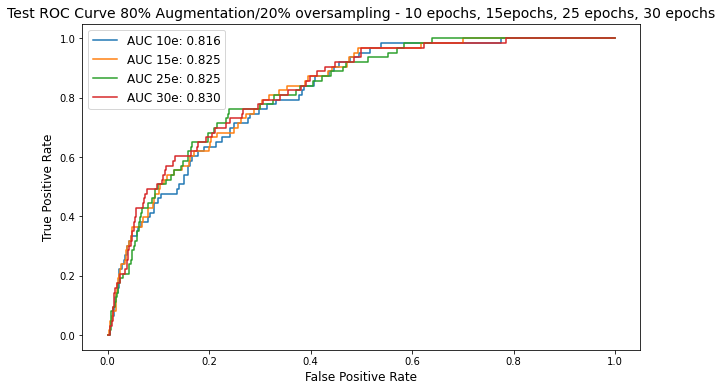

In [85]:
# Compare Test ROC Curve for 25 epochs vs 15 epochs vs 10 epochs
fig=plt.figure(figsize=(10,6))
AUC_10e= "{:.3f}".format(tb08_os2_roc_curve_stat['AUC'])
AUC_15e= "{:.3f}".format(e15_tb08_os2_roc_curve_stat['AUC'])
AUC_25e="{:.3f}".format(e25_tb08_os2_roc_curve_stat['AUC'])
AUC_30e="{:.3f}".format(e30_tb08_os2_roc_curve_stat['AUC'])
score_10e= "AUC 10e: " + str(AUC_10e)
score_15e= "AUC 15e: " + str(AUC_15e)
score_25e="AUC 25e: " + str(AUC_25e)
score_30e="AUC 30e: " + str(AUC_30e)
plt.plot(tb08_os2_roc_curve_stat['fpr'],tb08_os2_roc_curve_stat['tpr'], label=score_10e)
plt.plot(e15_tb08_os2_roc_curve_stat['fpr'],e15_tb08_os2_roc_curve_stat['tpr'], label=score_15e)
plt.plot(e25_tb08_os2_roc_curve_stat['fpr'],e25_tb08_os2_roc_curve_stat['tpr'], label=score_25e)
plt.plot(e30_tb08_os2_roc_curve_stat['fpr'],e30_tb08_os2_roc_curve_stat['tpr'], label=score_30e)
plt.title("Test ROC Curve 80% Augmentation/20% oversampling - 10 epochs, 15epochs, 25 epochs, 30 epochs", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

In [161]:
e30_tb08_os2_train_results=load_results("TrainedEffNetcheckpoint_Base_Epoch30_b32_tb08_os2_lr4.pth.tar")

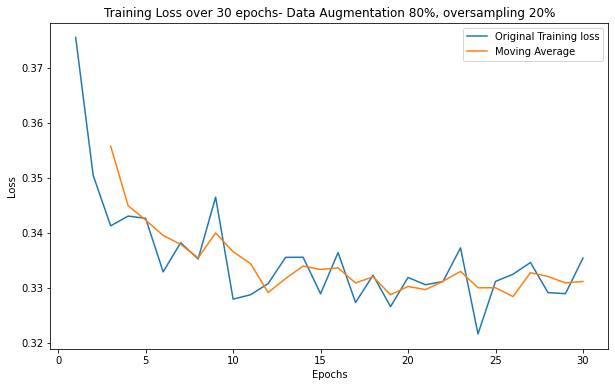

In [162]:
# Training Loss for 30 epoch run - plotted against moving average to visualise trend as the loss is volatile.

# moving average over 3 data points.
w=3
ma_train_loss = moving_average(e30_tb08_os2_train_results['train_loss'],w)

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e30_tb08_os2_train_results['train_loss']) + 1)
plt.plot(epoch_count, (e30_tb08_os2_train_results['train_loss']), label='Original Training loss')
ma_e_count = range(w, len(ma_train_loss)+w)
plt.plot(ma_e_count, ma_train_loss, label='Moving Average')

plt.title("Training Loss over 30 epochs- Data Augmentation 80%, oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

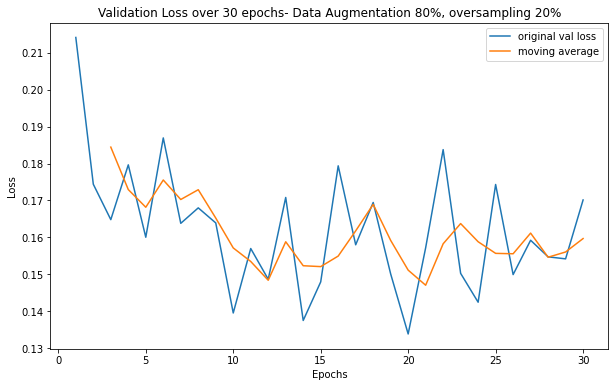

In [163]:
# Validation Loss for 30 epoch run - plotted against moving average to visualise trend as the loss is volatile.

# moving average over 3 data points.
fig=plt.figure(figsize=(10,6))
w=3
ma_val_loss = moving_average(e30_tb08_os2_train_results['val_loss'],w)
epoch_count = range(1, len(e30_tb08_os2_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e30_tb08_os2_train_results['val_loss']), label='original val loss')
ma_e_count = range(w, len(ma_val_loss)+w)
plt.plot(ma_e_count, ma_val_loss, label='moving average')
plt.title("Validation Loss over 30 epochs- Data Augmentation 80%, oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

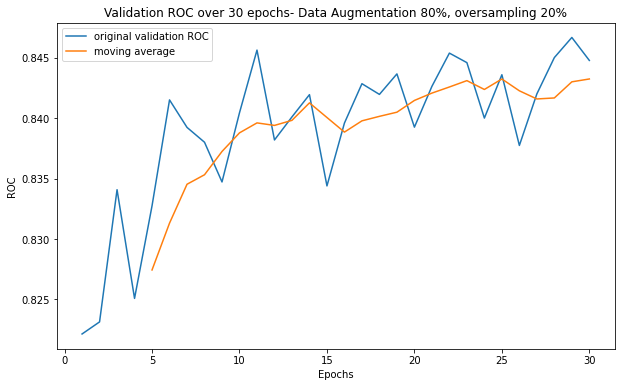

In [164]:
# validation ROC curve for 30 epoch run, learning rate 1e-4
fig=plt.figure(figsize=(10,6))
# MOVING AVERAGE OVER 5 DATA POINTS
w=5
ma_val_roc = moving_average(e30_tb08_os2_train_results['val_roc'],w)

epoch_count = range(1, len(e30_tb08_os2_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e30_tb08_os2_train_results['val_roc']), label='original validation ROC')

ma_e_count = range(w, len(ma_val_roc)+w)
plt.plot(ma_e_count, ma_val_roc, label='moving average')

plt.title("Validation ROC over 30 epochs- Data Augmentation 80%, oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

Conclusion: 
* Although test results demonstrate slight improvement in test ROC, training and validation loss appear to have converged
* No increase in validation ROC between 25epochs and 30 epochs.
* Will progress with 15 epochs which appears sufficient and avoids overfitting

### Investigating data augmentation probability

### Data augmentation 100%, oversampling ratio 20% - 15 epochs, lr 1e-4

In [28]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=1,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [29]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() # or BCELoss(need to apply additional sigmoid) or Focal Loss
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [30]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb1_os2= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Epoch15_b32_tb1_os2")


 epoch: 0, train loss: 0.379799, val loss: 0.214784, train acc: 0.8382, val acc: 0.9410, val roc:0.8074



 epoch: 1, train loss: 0.353381, val loss: 0.162227, train acc: 0.8460, val acc: 0.9667, val roc:0.8136



 epoch: 2, train loss: 0.345633, val loss: 0.164298, train acc: 0.8470, val acc: 0.9632, val roc:0.8253



 epoch: 3, train loss: 0.344492, val loss: 0.173051, train acc: 0.8484, val acc: 0.9629, val roc:0.8299



 epoch: 4, train loss: 0.345133, val loss: 0.175024, train acc: 0.8432, val acc: 0.9559, val roc:0.8393



 epoch: 5, train loss: 0.337846, val loss: 0.169396, train acc: 0.8499, val acc: 0.9601, val roc:0.8336



 epoch: 6, train loss: 0.342385, val loss: 0.170641, train acc: 0.8476, val acc: 0.9667, val roc:0.8274



 epoch: 7, train loss: 0.340598, val loss: 0.190763, train acc: 0.8496, val acc: 0.9574, val roc:0.8419



 epoch: 8, train loss: 0.347362, val loss: 0.166591, train acc: 0.8438, val acc: 0.9636, val roc:0.8349



 epoch: 9, train loss: 0.332793, val loss: 0.154464, train acc: 0.8524, val acc: 0.9635, val roc:0.8429



 epoch: 10, train loss: 0.330251, val loss: 0.156895, train acc: 0.8539, val acc: 0.9636, val roc:0.8467



 epoch: 11, train loss: 0.333546, val loss: 0.143772, train acc: 0.8494, val acc: 0.9653, val roc:0.8332



 epoch: 12, train loss: 0.339435, val loss: 0.179517, train acc: 0.8460, val acc: 0.9536, val roc:0.8310



 epoch: 13, train loss: 0.342036, val loss: 0.138379, train acc: 0.8470, val acc: 0.9740, val roc:0.8292



 epoch: 14, train loss: 0.334339, val loss: 0.156178, train acc: 0.8525, val acc: 0.9647, val roc:0.8255
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Epoch15_b32_tb1_os2.pth.tar saved.
Training Finished
Training and validation time: 12053.35455274582 seconds


In [98]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Epoch15_b32_tb1_os2.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [99]:
e15_tb1_os2_test_results, e15_tb1_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [33]:
e15_tb1_os2_test_results

{'test_accuracy': 0.9621367772233637,
 'test_roc_score': 0.8117737525632263,
 'CM': array([[3268,   76],
        [  53,   10]], dtype=int64)}

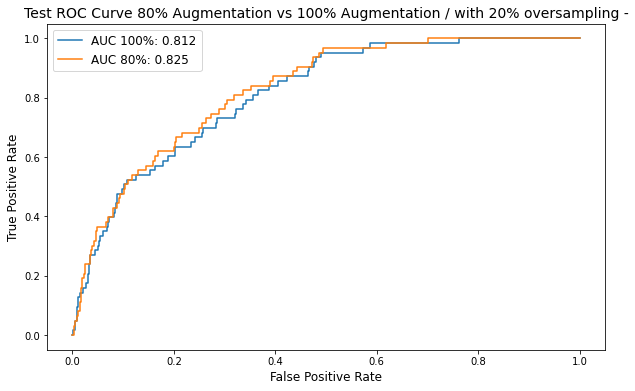

In [100]:
# Compare Test ROC between 80% augmentation and 100% augmentation

fig=plt.figure(figsize=(10,6))

AUC_100="{:.3f}".format(e15_tb1_os2_roc_curve_stat['AUC'])
AUC_80="{:.3f}".format(e15_tb08_os2_roc_curve_stat['AUC'])
score_100= "AUC 100%: " + str(AUC_100)
score_80= "AUC 80%: " + str(AUC_80)
plt.plot(e15_tb1_os2_roc_curve_stat['fpr'],e15_tb1_os2_roc_curve_stat['tpr'], label=score_100)
plt.plot(e15_tb08_os2_roc_curve_stat['fpr'],e15_tb08_os2_roc_curve_stat['tpr'], label=score_80)
plt.title("Test ROC Curve 80% Augmentation vs 100% Augmentation / with 20% oversampling -", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

In [165]:
# Load results
e15_tb08_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb08_os2.pth.tar")
e15_tb1_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb1_os2.pth.tar")

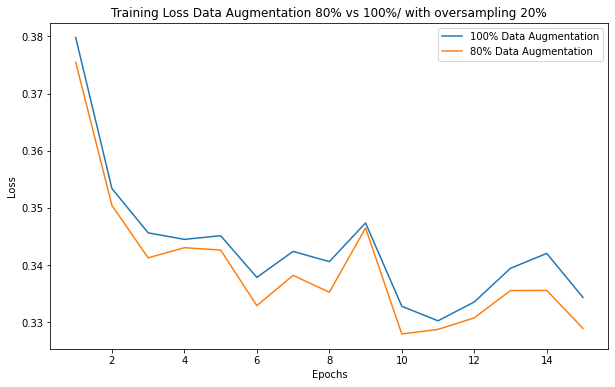

In [166]:
# Training Loss comparison 80% Augmentnation vs 100% Augmentation

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb08_os2_train_results['train_loss']) + 1)
plt.plot(epoch_count, (e15_tb1_os2_train_results['train_loss']), label='100% Data Augmentation')
plt.plot(epoch_count, (e15_tb08_os2_train_results['train_loss']), label='80% Data Augmentation')
plt.title("Training Loss Data Augmentation 80% vs 100%/ with oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

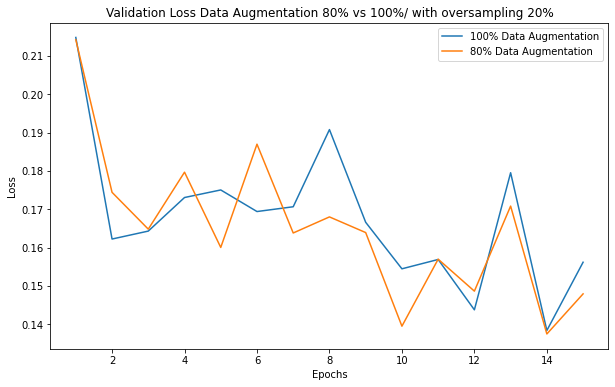

In [167]:
# Validation Loss comparison 80% Augmentnation vs 100% Augmentation

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb08_os2_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e15_tb1_os2_train_results['val_loss']), label='100% Data Augmentation')
plt.plot(epoch_count, (e15_tb08_os2_train_results['val_loss']), label='80% Data Augmentation')
plt.title("Validation Loss Data Augmentation 80% vs 100%/ with oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

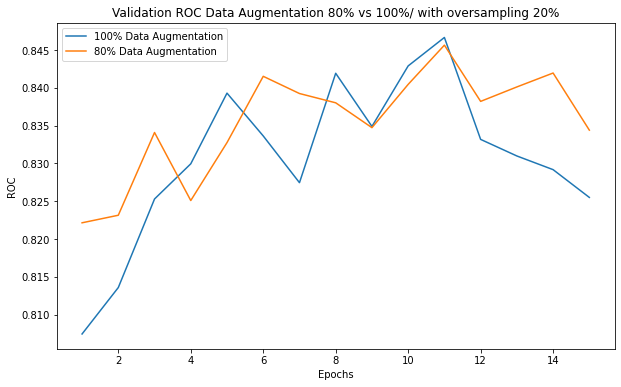

In [168]:
# Validation ROC comparison 80% Augmentnation vs 100% Augmentation
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb08_os2_train_results['val_roc']) + 1)
plt.plot(epoch_count, (e15_tb1_os2_train_results['val_roc']), label='100% Data Augmentation')
plt.plot(epoch_count, (e15_tb08_os2_train_results['val_roc']), label='80% Data Augmentation')
plt.title("Validation ROC Data Augmentation 80% vs 100%/ with oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

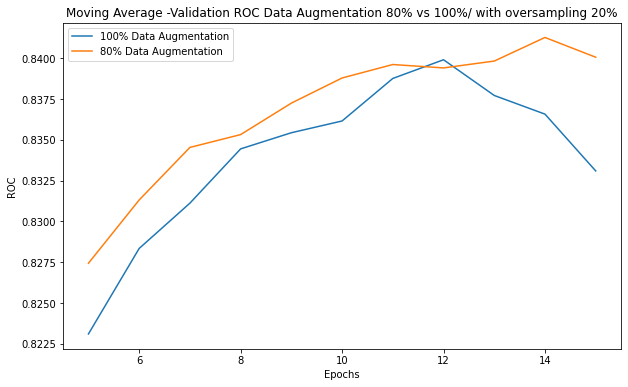

In [169]:
# Validation ROC Moving average comparison 80% Augmentnation vs 100% Augmentation
fig=plt.figure(figsize=(10,6))
w=5
ma_val_roc_100 = moving_average(e15_tb1_os2_train_results['val_roc'],w)
ma_val_roc_80 = moving_average(e15_tb08_os2_train_results['val_roc'],w)
ma_e_count = range(w, len(ma_val_roc_100)+w)
plt.plot(ma_e_count, ma_val_roc_100, label='100% Data Augmentation')
plt.plot(ma_e_count, ma_val_roc_80, label='80% Data Augmentation')
plt.title("Moving Average -Validation ROC Data Augmentation 80% vs 100%/ with oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()


### Data augmentation 50%, oversampling ratio 20%

In [35]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [36]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [37]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb05_os2= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Epoch15_b32_tb05_os2")


 epoch: 0, train loss: 0.368132, val loss: 0.209165, train acc: 0.8453, val acc: 0.9311, val roc:0.8303



 epoch: 1, train loss: 0.342753, val loss: 0.169459, train acc: 0.8500, val acc: 0.9573, val roc:0.8356



 epoch: 2, train loss: 0.330831, val loss: 0.180643, train acc: 0.8538, val acc: 0.9462, val roc:0.8423



 epoch: 3, train loss: 0.333202, val loss: 0.180721, train acc: 0.8519, val acc: 0.9497, val roc:0.8435



 epoch: 4, train loss: 0.331494, val loss: 0.163284, train acc: 0.8500, val acc: 0.9527, val roc:0.8456



 epoch: 5, train loss: 0.324000, val loss: 0.177326, train acc: 0.8575, val acc: 0.9492, val roc:0.8475



 epoch: 6, train loss: 0.326258, val loss: 0.192460, train acc: 0.8553, val acc: 0.9434, val roc:0.8499



 epoch: 7, train loss: 0.323935, val loss: 0.171728, train acc: 0.8544, val acc: 0.9597, val roc:0.8485



 epoch: 8, train loss: 0.333817, val loss: 0.160775, train acc: 0.8484, val acc: 0.9573, val roc:0.8506



 epoch: 9, train loss: 0.318799, val loss: 0.142855, train acc: 0.8579, val acc: 0.9627, val roc:0.8477



 epoch: 10, train loss: 0.317574, val loss: 0.162269, train acc: 0.8587, val acc: 0.9512, val roc:0.8491



 epoch: 11, train loss: 0.321233, val loss: 0.144023, train acc: 0.8566, val acc: 0.9605, val roc:0.8403



 epoch: 12, train loss: 0.325401, val loss: 0.162432, train acc: 0.8551, val acc: 0.9547, val roc:0.8393



 epoch: 13, train loss: 0.325799, val loss: 0.143820, train acc: 0.8526, val acc: 0.9588, val roc:0.8543



 epoch: 14, train loss: 0.319293, val loss: 0.152155, train acc: 0.8592, val acc: 0.9618, val roc:0.8441
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2.pth.tar saved.
Training Finished
Training and validation time: 9263.8066573143 seconds


In [52]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [53]:
e15_tb05_os2_test_results, e15_tb05_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [40]:
e15_tb05_os2_test_results

{'test_accuracy': 0.961843263868506,
 'test_roc_score': 0.824115212273107,
 'CM': array([[3265,   79],
        [  51,   12]], dtype=int64)}

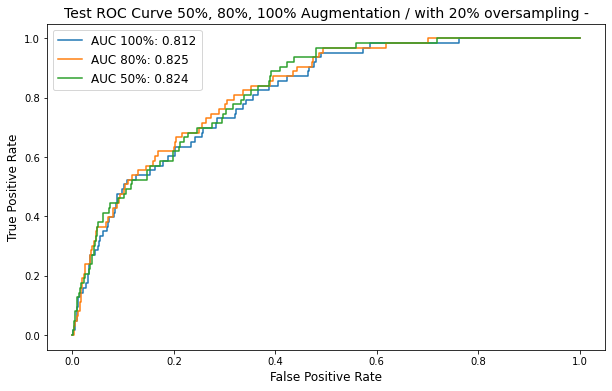

In [113]:
# Plot test ROC results 50% vs 80% vs 100% Data Augmentation

fig=plt.figure(figsize=(10,6))
AUC_100="{:.3f}".format(e15_tb1_os2_roc_curve_stat['AUC'])
AUC_80="{:.3f}".format(e15_tb08_os2_roc_curve_stat['AUC'])
AUC_50="{:.3f}".format(e15_tb05_os2_roc_curve_stat['AUC'])
score_100= "AUC 100%: " + str(AUC_100)
score_80= "AUC 80%: " + str(AUC_80)
score_50= "AUC 50%: " + str(AUC_50)
plt.plot(e15_tb1_os2_roc_curve_stat['fpr'],e15_tb1_os2_roc_curve_stat['tpr'], label=score_100)
plt.plot(e15_tb08_os2_roc_curve_stat['fpr'],e15_tb08_os2_roc_curve_stat['tpr'], label=score_80)
plt.plot(e15_tb05_os2_roc_curve_stat['fpr'],e15_tb05_os2_roc_curve_stat['tpr'], label=score_50)
plt.title("Test ROC Curve 50%, 80%, 100% Augmentation / with 20% oversampling -", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

In [170]:
# Load results
e15_tb05_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2.pth.tar")
e15_tb08_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb08_os2.pth.tar")
e15_tb1_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb1_os2.pth.tar")

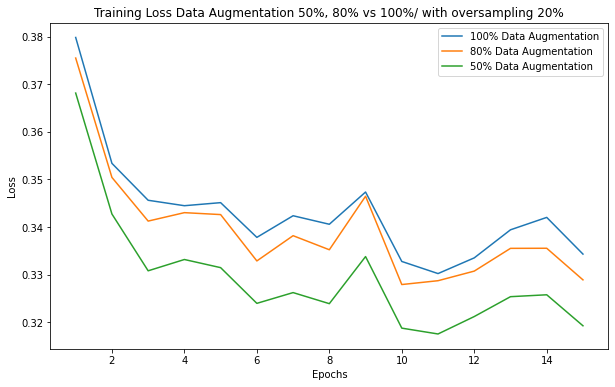

In [171]:
# Training Loss comparison 50% Augmentation, 80% Augmentation vs 100% Augmentation

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb08_os2_train_results['train_loss']) + 1)
plt.plot(epoch_count, (e15_tb1_os2_train_results['train_loss']), label='100% Data Augmentation')
plt.plot(epoch_count, (e15_tb08_os2_train_results['train_loss']), label='80% Data Augmentation')
plt.plot(epoch_count, (e15_tb05_os2_train_results['train_loss']), label='50% Data Augmentation')
plt.title("Training Loss Data Augmentation 50%, 80% vs 100%/ with oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

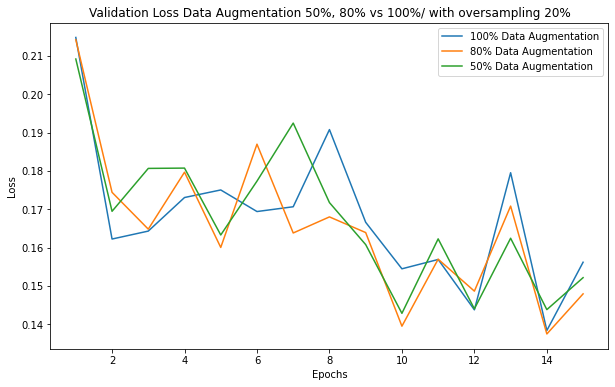

In [172]:
# Validation Loss comparison 50% Augmentation, 80% Augmentation vs 100% Augmentation

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb08_os2_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e15_tb1_os2_train_results['val_loss']), label='100% Data Augmentation')
plt.plot(epoch_count, (e15_tb08_os2_train_results['val_loss']), label='80% Data Augmentation')
plt.plot(epoch_count, (e15_tb05_os2_train_results['val_loss']), label='50% Data Augmentation')
plt.title("Validation Loss Data Augmentation 50%, 80% vs 100%/ with oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

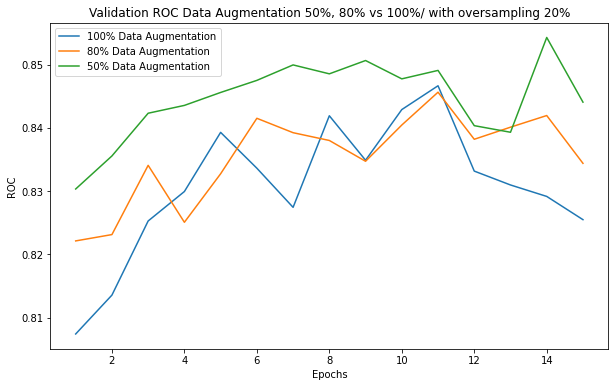

In [173]:
# Validation ROC comparison 50% Augmentation, 80% Augmentation vs 100% Augmentation

fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb08_os2_train_results['val_roc']) + 1)
plt.plot(epoch_count, (e15_tb1_os2_train_results['val_roc']), label='100% Data Augmentation')
plt.plot(epoch_count, (e15_tb08_os2_train_results['val_roc']), label='80% Data Augmentation')
plt.plot(epoch_count, (e15_tb05_os2_train_results['val_roc']), label='50% Data Augmentation')
plt.title("Validation ROC Data Augmentation 50%, 80% vs 100%/ with oversampling 20%", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

In [ ]:
# 20% transform

In [72]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [73]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [74]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb02_os2= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Epoch15_b32_tb02_os2")


 epoch: 0, train loss: 0.357671, val loss: 0.193655, train acc: 0.8484, val acc: 0.9370, val roc:0.8387



 epoch: 1, train loss: 0.325863, val loss: 0.158173, train acc: 0.8578, val acc: 0.9592, val roc:0.8393



 epoch: 2, train loss: 0.311453, val loss: 0.184529, train acc: 0.8627, val acc: 0.9360, val roc:0.8512



 epoch: 3, train loss: 0.312774, val loss: 0.176794, train acc: 0.8629, val acc: 0.9439, val roc:0.8445



 epoch: 4, train loss: 0.311717, val loss: 0.160378, train acc: 0.8634, val acc: 0.9487, val roc:0.8498



 epoch: 5, train loss: 0.305720, val loss: 0.181707, train acc: 0.8660, val acc: 0.9398, val roc:0.8425



 epoch: 6, train loss: 0.310330, val loss: 0.172943, train acc: 0.8626, val acc: 0.9477, val roc:0.8409



 epoch: 7, train loss: 0.302146, val loss: 0.170370, train acc: 0.8655, val acc: 0.9501, val roc:0.8457



 epoch: 8, train loss: 0.314485, val loss: 0.157655, train acc: 0.8596, val acc: 0.9560, val roc:0.8439



 epoch: 9, train loss: 0.299803, val loss: 0.138564, train acc: 0.8661, val acc: 0.9615, val roc:0.8459



 epoch: 10, train loss: 0.300944, val loss: 0.155644, train acc: 0.8661, val acc: 0.9507, val roc:0.8540



 epoch: 11, train loss: 0.303033, val loss: 0.144619, train acc: 0.8628, val acc: 0.9574, val roc:0.8339



 epoch: 12, train loss: 0.307302, val loss: 0.164445, train acc: 0.8619, val acc: 0.9490, val roc:0.8370



 epoch: 13, train loss: 0.306581, val loss: 0.146884, train acc: 0.8629, val acc: 0.9571, val roc:0.8492



 epoch: 14, train loss: 0.297856, val loss: 0.154200, train acc: 0.8680, val acc: 0.9562, val roc:0.8438
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Epoch15_b32_tb02_os2.pth.tar saved.
Training Finished
Training and validation time: 9526.109062671661 seconds


Conclusion: 
* Loss is higher with higher transform probability this difference is potentially because increased data augmentation probability results in more new data for the model in each batch. This can also contribute to more noise, which is seen with 100% transformation probability
* Test ROC results are lower with higher transform probability, with similar results for 80% vs 50% transformation probability in data augmentation, of ~0.825
* Going forward we will use 50% transform probability as it is more stable with not much difference in test ROC results

## Investigating Learning Rate

### Learning rate 1e-3, Data Augmentation 50% and Oversampling 20%

In [69]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, 
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [72]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion= nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [73]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb05_os2_lr3= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Epoch15_b32_tb05_os2_lr3")


 epoch: 0, train loss: 0.360746, val loss: 0.154219, train acc: 0.8460, val acc: 0.9521, val roc:0.8275



 epoch: 1, train loss: 0.347267, val loss: 0.182718, train acc: 0.8492, val acc: 0.9536, val roc:0.8354



 epoch: 2, train loss: 0.336110, val loss: 0.190283, train acc: 0.8521, val acc: 0.9557, val roc:0.8426



 epoch: 3, train loss: 0.338056, val loss: 0.214091, train acc: 0.8497, val acc: 0.9299, val roc:0.8416



 epoch: 4, train loss: 0.337354, val loss: 0.155349, train acc: 0.8482, val acc: 0.9548, val roc:0.8424



 epoch: 5, train loss: 0.329070, val loss: 0.155383, train acc: 0.8567, val acc: 0.9547, val roc:0.8455



 epoch: 6, train loss: 0.330787, val loss: 0.174574, train acc: 0.8553, val acc: 0.9516, val roc:0.8432



 epoch: 7, train loss: 0.329769, val loss: 0.166461, train acc: 0.8555, val acc: 0.9646, val roc:0.8489



 epoch: 8, train loss: 0.338780, val loss: 0.143335, train acc: 0.8477, val acc: 0.9563, val roc:0.8507



 epoch: 9, train loss: 0.324046, val loss: 0.137398, train acc: 0.8565, val acc: 0.9624, val roc:0.8440



 epoch: 10, train loss: 0.322376, val loss: 0.177653, train acc: 0.8589, val acc: 0.9354, val roc:0.8504



 epoch: 11, train loss: 0.325633, val loss: 0.141471, train acc: 0.8545, val acc: 0.9571, val roc:0.8337



 epoch: 12, train loss: 0.330920, val loss: 0.143767, train acc: 0.8538, val acc: 0.9630, val roc:0.8335



 epoch: 13, train loss: 0.330764, val loss: 0.140689, train acc: 0.8529, val acc: 0.9525, val roc:0.8539



 epoch: 14, train loss: 0.323506, val loss: 0.155081, train acc: 0.8585, val acc: 0.9609, val roc:0.8438
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2_lr3.pth.tar saved.
Training Finished
Training and validation time: 9157.906020879745 seconds


In [41]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-3
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2_lr3.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [42]:
e15_tb05_os2_lr3_test_results, e15_tb05_os2_lr3_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [43]:
e15_tb05_os2_lr3_test_results

{'test_accuracy': 0.9603756970942178,
 'test_roc_score': 0.8266974253816359,
 'CM': array([[3260,   84],
        [  51,   12]], dtype=int64)}

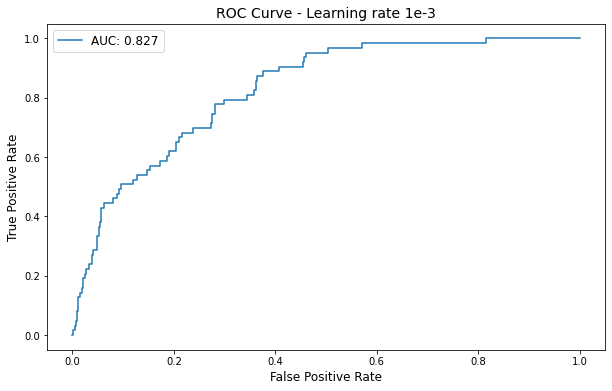

In [44]:
plot_roc(e15_tb05_os2_lr3_roc_curve_stat, title="ROC Curve - Learning rate 1e-3")

### Learning rate 1e-5, Data Augmentation 50% and Oversampling 20%

In [74]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [77]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() # or BCELoss(need to apply additional sigmoid) or Focal Loss
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [78]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb05_os2_lr5= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch15_b32_tb05_os2_lr5")


 epoch: 0, train loss: 0.471933, val loss: 0.260830, train acc: 0.8271, val acc: 0.9585, val roc:0.7341



 epoch: 1, train loss: 0.391723, val loss: 0.234599, train acc: 0.8342, val acc: 0.9358, val roc:0.7948



 epoch: 2, train loss: 0.367808, val loss: 0.226978, train acc: 0.8427, val acc: 0.9328, val roc:0.8156



 epoch: 3, train loss: 0.361761, val loss: 0.202200, train acc: 0.8434, val acc: 0.9471, val roc:0.8192



 epoch: 4, train loss: 0.352388, val loss: 0.208549, train acc: 0.8448, val acc: 0.9375, val roc:0.8284



 epoch: 5, train loss: 0.343227, val loss: 0.196874, train acc: 0.8528, val acc: 0.9439, val roc:0.8309



 epoch: 6, train loss: 0.339907, val loss: 0.193431, train acc: 0.8515, val acc: 0.9458, val roc:0.8337



 epoch: 7, train loss: 0.335845, val loss: 0.185805, train acc: 0.8530, val acc: 0.9495, val roc:0.8363



 epoch: 8, train loss: 0.343435, val loss: 0.190207, train acc: 0.8464, val acc: 0.9462, val roc:0.8416



 epoch: 9, train loss: 0.327053, val loss: 0.185800, train acc: 0.8561, val acc: 0.9454, val roc:0.8423



 epoch: 10, train loss: 0.321722, val loss: 0.179091, train acc: 0.8584, val acc: 0.9469, val roc:0.8456



 epoch: 11, train loss: 0.325574, val loss: 0.165742, train acc: 0.8566, val acc: 0.9554, val roc:0.8424



 epoch: 12, train loss: 0.328520, val loss: 0.182382, train acc: 0.8544, val acc: 0.9465, val roc:0.8420



 epoch: 13, train loss: 0.328054, val loss: 0.157638, train acc: 0.8558, val acc: 0.9574, val roc:0.8464



 epoch: 14, train loss: 0.322198, val loss: 0.160029, train acc: 0.8586, val acc: 0.9559, val roc:0.8454
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_lr5.pth.tar saved.
Training Finished
Training and validation time: 8759.137921333313 seconds


In [45]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-5
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_lr5.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [46]:
e15_tb05_os2_lr5_test_results, e15_tb05_os2_lr5_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [47]:
e15_tb05_os2_lr5_test_results

{'test_accuracy': 0.9559729967713531,
 'test_roc_score': 0.8284157363104732,
 'CM': array([[3244,  100],
        [  50,   13]], dtype=int64)}

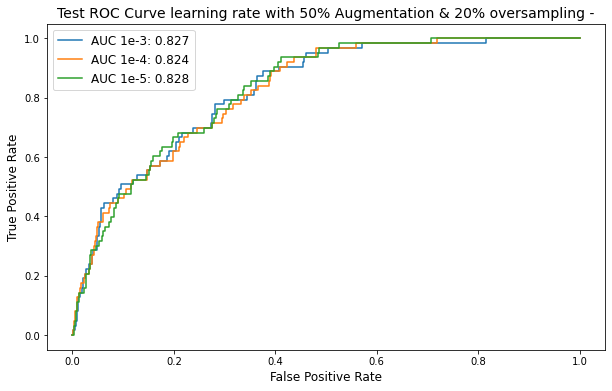

In [126]:
# Plot test ROC results learning rates
fig=plt.figure(figsize=(10,6))
AUC_1e3="{:.3f}".format(e15_tb05_os2_lr3_roc_curve_stat['AUC'])
AUC_1e4="{:.3f}".format(e15_tb05_os2_roc_curve_stat['AUC'])
AUC_1e5="{:.3f}".format(e15_tb05_os2_lr5_roc_curve_stat['AUC'])
score_1e3= "AUC 1e-3: " + str(AUC_1e3)
score_1e4= "AUC 1e-4: " + str(AUC_1e4)
score_1e5= "AUC 1e-5: " + str(AUC_1e5)
plt.plot(e15_tb05_os2_lr3_roc_curve_stat['fpr'],e15_tb05_os2_lr3_roc_curve_stat['tpr'], label=score_1e3)
plt.plot(e15_tb05_os2_roc_curve_stat['fpr'],e15_tb05_os2_roc_curve_stat['tpr'], label=score_1e4)
plt.plot(e15_tb05_os2_lr5_roc_curve_stat['fpr'],e15_tb05_os2_lr5_roc_curve_stat['tpr'], label=score_1e5)
plt.title("Test ROC Curve learning rate with 50% Augmentation & 20% oversampling -", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

In [174]:
# Load results
e15_tb05_os2_lr3_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2_lr3.pth.tar")
e15_tb05_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2.pth.tar")
e15_tb05_os2_lr5_train_results=load_results("TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_lr5.pth.tar")

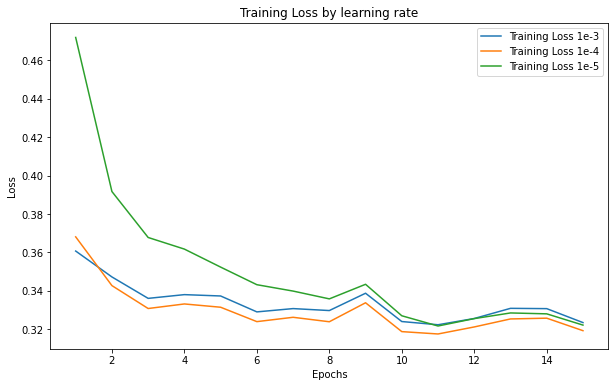

In [175]:
# Training loss by learning rate
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os2_lr3_train_results['train_loss']) + 1)
plt.plot(epoch_count, (e15_tb05_os2_lr3_train_results['train_loss']), label='Training Loss 1e-3')
plt.plot(epoch_count, (e15_tb05_os2_train_results['train_loss']), label='Training Loss 1e-4')
plt.plot(epoch_count, (e15_tb05_os2_lr5_train_results['train_loss']), label='Training Loss 1e-5')
plt.title("Training Loss by learning rate", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

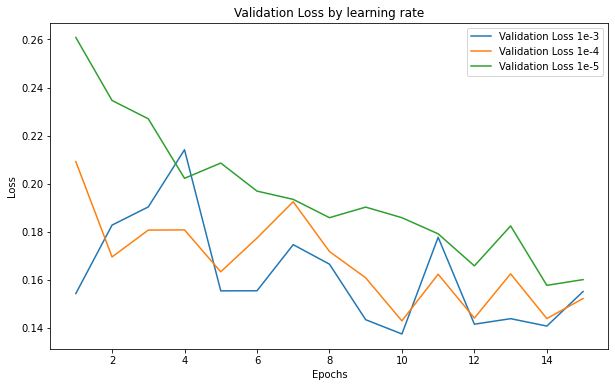

In [176]:
# Validation loss by learning rate
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os2_lr3_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e15_tb05_os2_lr3_train_results['val_loss']), label='Validation Loss 1e-3')
plt.plot(epoch_count, (e15_tb05_os2_train_results['val_loss']), label='Validation Loss 1e-4')
plt.plot(epoch_count, (e15_tb05_os2_lr5_train_results['val_loss']), label='Validation Loss 1e-5')
plt.title("Validation Loss by learning rate", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

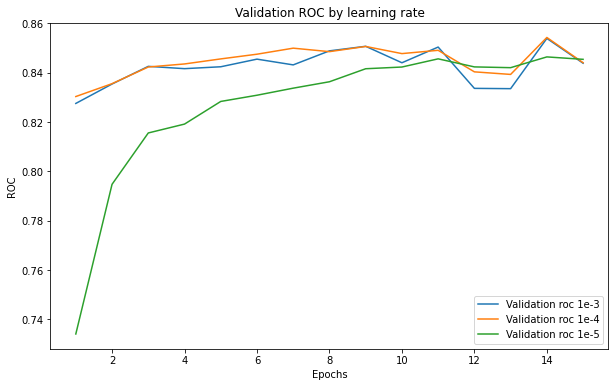

In [177]:
# Validation ROC by learning rate
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os2_lr3_train_results['val_roc']) + 1)
plt.plot(epoch_count, (e15_tb05_os2_lr3_train_results['val_roc']), label='Validation roc 1e-3')
plt.plot(epoch_count, (e15_tb05_os2_train_results['val_roc']), label='Validation roc 1e-4')
plt.plot(epoch_count, (e15_tb05_os2_lr5_train_results['val_roc']), label='Validation roc 1e-5')
plt.title("Validation ROC by learning rate", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

 Conclusion :
 * ROC test results are similar across all learning rates
 * However, faster convergence is demosntrated for learning rate 1e-4 and 1e-3 with  validation ROC demonstrate a learning rate of 1e-4 is more stable and faster to converge
 * Going forward will use a learning rate of 1e-4

### Learning rate 1e-4 with Weight Decay, Data Augmentation 50% and Oversampling 20%

In [30]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [31]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() # or BCELoss(need to apply additional sigmoid) or Focal Loss
optimizer= optim.AdamW(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [32]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb05_os2_WD= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch15_b32_tb05_os2_WD")


 epoch: 0, train loss: 0.368137, val loss: 0.209184, train acc: 0.8453, val acc: 0.9311, val roc:0.8303



 epoch: 1, train loss: 0.342760, val loss: 0.169484, train acc: 0.8500, val acc: 0.9573, val roc:0.8355



 epoch: 2, train loss: 0.330841, val loss: 0.180677, train acc: 0.8538, val acc: 0.9462, val roc:0.8423



 epoch: 3, train loss: 0.333216, val loss: 0.180804, train acc: 0.8519, val acc: 0.9497, val roc:0.8435



 epoch: 4, train loss: 0.331511, val loss: 0.163301, train acc: 0.8501, val acc: 0.9527, val roc:0.8456



 epoch: 5, train loss: 0.324020, val loss: 0.177359, train acc: 0.8575, val acc: 0.9492, val roc:0.8475



 epoch: 6, train loss: 0.326278, val loss: 0.192541, train acc: 0.8553, val acc: 0.9434, val roc:0.8499



 epoch: 7, train loss: 0.323959, val loss: 0.171761, train acc: 0.8544, val acc: 0.9597, val roc:0.8485



 epoch: 8, train loss: 0.333840, val loss: 0.160762, train acc: 0.8483, val acc: 0.9573, val roc:0.8506



 epoch: 9, train loss: 0.318829, val loss: 0.142863, train acc: 0.8579, val acc: 0.9626, val roc:0.8477



 epoch: 10, train loss: 0.317600, val loss: 0.162321, train acc: 0.8587, val acc: 0.9513, val roc:0.8491



 epoch: 11, train loss: 0.321261, val loss: 0.143995, train acc: 0.8565, val acc: 0.9606, val roc:0.8403



 epoch: 12, train loss: 0.325435, val loss: 0.162427, train acc: 0.8550, val acc: 0.9547, val roc:0.8392



 epoch: 13, train loss: 0.325834, val loss: 0.143839, train acc: 0.8527, val acc: 0.9588, val roc:0.8542



 epoch: 14, train loss: 0.319330, val loss: 0.152210, train acc: 0.8593, val acc: 0.9618, val roc:0.8441
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_WD.pth.tar saved.
Training Finished
Training and validation time: 9126.817113399506 seconds


In [48]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-5
optimizer= optim.AdamW(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_WD.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [49]:
e15_tb05_os2_lr4wd_test_results, e15_tb05_os2_lr4wd_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [50]:
e15_tb05_os2_lr4wd_test_results

{'test_accuracy': 0.9615497505136483,
 'test_roc_score': 0.8240582516898307,
 'CM': array([[3264,   80],
        [  51,   12]], dtype=int64)}

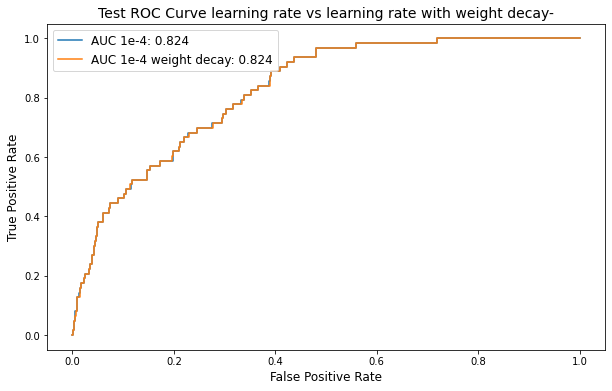

In [54]:
# Plot test ROC results 1e-4 learning rate vs 1e-4 learning rate with weight decay 0.01

fig=plt.figure(figsize=(10,6))
AUC_1e4="{:.3f}".format(e15_tb05_os2_roc_curve_stat['AUC'])
AUC_WD="{:.3f}".format(e15_tb05_os2_lr4wd_roc_curve_stat['AUC'])
score_1e4= "AUC 1e-4: " + str(AUC_1e4)
score_wd= "AUC 1e-4 weight decay: " + str(AUC_WD)
plt.plot(e15_tb05_os2_roc_curve_stat['fpr'],e15_tb05_os2_roc_curve_stat['tpr'], label=score_1e4)
plt.plot(e15_tb05_os2_lr4wd_roc_curve_stat['fpr'],e15_tb05_os2_lr4wd_roc_curve_stat['tpr'], label=score_wd)
plt.title("Test ROC Curve learning rate vs learning rate with weight decay-", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

Conclusion: 
* Use of AdamW to include Weight decay for the Adam optimize did not demonstrate an improvement

## Investigating Oversampling
###  NOTE: Only training data is oversampled for Melanoma target variable not validation or test data
### Oversampling rate 50% with 50% Data Augmentation and learning rate 1 e-4

In [79]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.5)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [82]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [83]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb05_os5_lr4= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch15_b32_tb05_os5_lr4")


 epoch: 0, train loss: 0.477073, val loss: 0.305351, train acc: 0.7650, val acc: 0.8815, val roc:0.8373



 epoch: 1, train loss: 0.443102, val loss: 0.271292, train acc: 0.7824, val acc: 0.8963, val roc:0.8481



 epoch: 2, train loss: 0.436856, val loss: 0.324116, train acc: 0.7874, val acc: 0.8674, val roc:0.8516



 epoch: 3, train loss: 0.438558, val loss: 0.254121, train acc: 0.7853, val acc: 0.9074, val roc:0.8571



 epoch: 4, train loss: 0.437156, val loss: 0.271506, train acc: 0.7863, val acc: 0.8979, val roc:0.8470



 epoch: 5, train loss: 0.423226, val loss: 0.286690, train acc: 0.7965, val acc: 0.8818, val roc:0.8444



 epoch: 6, train loss: 0.431462, val loss: 0.313453, train acc: 0.7912, val acc: 0.8719, val roc:0.8435



 epoch: 7, train loss: 0.430435, val loss: 0.250983, train acc: 0.7893, val acc: 0.9068, val roc:0.8477



 epoch: 8, train loss: 0.428373, val loss: 0.326378, train acc: 0.7932, val acc: 0.8611, val roc:0.8452



 epoch: 9, train loss: 0.427713, val loss: 0.292904, train acc: 0.7936, val acc: 0.8794, val roc:0.8443



 epoch: 10, train loss: 0.429340, val loss: 0.292413, train acc: 0.7927, val acc: 0.8827, val roc:0.8505



 epoch: 11, train loss: 0.427265, val loss: 0.281882, train acc: 0.7913, val acc: 0.8893, val roc:0.8433



 epoch: 12, train loss: 0.429035, val loss: 0.263524, train acc: 0.7913, val acc: 0.9011, val roc:0.8480



 epoch: 13, train loss: 0.426573, val loss: 0.267200, train acc: 0.7958, val acc: 0.8912, val roc:0.8516



 epoch: 14, train loss: 0.429232, val loss: 0.264544, train acc: 0.7922, val acc: 0.9028, val roc:0.8531
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os5_lr4.pth.tar saved.
Training Finished
Training and validation time: 8704.59791302681 seconds


In [55]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os5_lr4.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [56]:
e15_tb05_os5_test_results, e15_tb05_os5_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [57]:
e15_tb05_os5_test_results

{'test_accuracy': 0.9078368065746991,
 'test_roc_score': 0.8350041771094403,
 'CM': array([[3062,  282],
        [  32,   31]], dtype=int64)}

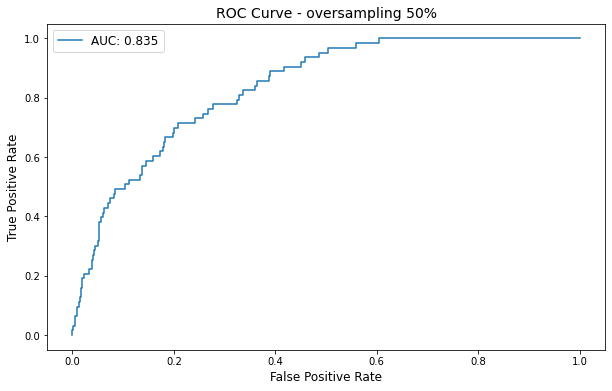

In [58]:
plot_roc(e15_tb05_os5_roc_curve_stat, title="ROC Curve - oversampling 50%")

### Oversampling rate 10% with  50% Data Augmentation and learning rate 1 e-4

In [84]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)

In [85]:
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, test_set=test_set, batch_size=32, oversampling_ratio=0.1)

In [86]:
# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [87]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [88]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb05_os1_lr4= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch15_b32_tb05_os1_lr4")


 epoch: 0, train loss: 0.280380, val loss: 0.151288, train acc: 0.9051, val acc: 0.9629, val roc:0.8025



 epoch: 1, train loss: 0.248319, val loss: 0.137739, train acc: 0.9068, val acc: 0.9697, val roc:0.8264



 epoch: 2, train loss: 0.236707, val loss: 0.124330, train acc: 0.9134, val acc: 0.9738, val roc:0.8304



 epoch: 3, train loss: 0.239285, val loss: 0.113791, train acc: 0.9089, val acc: 0.9726, val roc:0.8294



 epoch: 4, train loss: 0.236796, val loss: 0.098943, train acc: 0.9114, val acc: 0.9801, val roc:0.8300



 epoch: 5, train loss: 0.231975, val loss: 0.114712, train acc: 0.9102, val acc: 0.9740, val roc:0.8348



 epoch: 6, train loss: 0.232158, val loss: 0.113523, train acc: 0.9120, val acc: 0.9722, val roc:0.8429



 epoch: 7, train loss: 0.225157, val loss: 0.120562, train acc: 0.9159, val acc: 0.9752, val roc:0.8254



 epoch: 8, train loss: 0.234634, val loss: 0.101890, train acc: 0.9098, val acc: 0.9773, val roc:0.8444



 epoch: 9, train loss: 0.225147, val loss: 0.104077, train acc: 0.9142, val acc: 0.9778, val roc:0.8391



 epoch: 10, train loss: 0.233757, val loss: 0.103078, train acc: 0.9079, val acc: 0.9755, val roc:0.8411



 epoch: 11, train loss: 0.227906, val loss: 0.122128, train acc: 0.9144, val acc: 0.9688, val roc:0.8371



 epoch: 12, train loss: 0.227739, val loss: 0.104285, train acc: 0.9131, val acc: 0.9770, val roc:0.8518



 epoch: 13, train loss: 0.224793, val loss: 0.111345, train acc: 0.9143, val acc: 0.9697, val roc:0.8562



 epoch: 14, train loss: 0.230870, val loss: 0.107647, train acc: 0.9103, val acc: 0.9755, val roc:0.8418
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os1_lr4.pth.tar saved.
Training Finished
Training and validation time: 9166.225392818451 seconds


In [59]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os1_lr4.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [60]:
e15_tb05_os1_test_results, e15_tb05_os1_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [61]:
e15_tb05_os1_test_results

{'test_accuracy': 0.9750513648371001,
 'test_roc_score': 0.8212719298245613,
 'CM': array([[3319,   25],
        [  60,    3]], dtype=int64)}

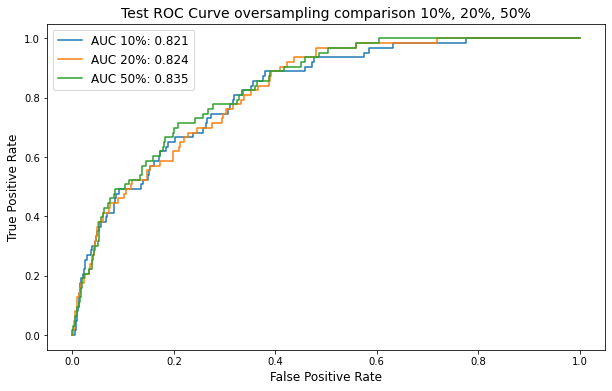

In [146]:
# Test ROC comparison of different oversampling levels

fig=plt.figure(figsize=(10,6))
AUC_10="{:.3f}".format(e15_tb05_os1_roc_curve_stat['AUC'])
AUC_20="{:.3f}".format(e15_tb05_os2_roc_curve_stat['AUC'])
AUC_50="{:.3f}".format(e15_tb05_os5_roc_curve_stat['AUC'])
score_10= "AUC 10%: " + str(AUC_10)
score_20= "AUC 20%: " + str(AUC_20)
score_50= "AUC 50%: " + str(AUC_50)
plt.plot(e15_tb05_os1_roc_curve_stat['fpr'],e15_tb05_os1_roc_curve_stat['tpr'], label=score_10)
plt.plot(e15_tb05_os2_roc_curve_stat['fpr'],e15_tb05_os2_roc_curve_stat['tpr'], label=score_20)
plt.plot(e15_tb05_os5_roc_curve_stat['fpr'],e15_tb05_os5_roc_curve_stat['tpr'], label=score_50)
plt.title("Test ROC Curve oversampling comparison 10%, 20%, 50%", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

In [62]:
# Load results for comparison
e15_tb05_os1_train_results=load_results("TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os1_lr4.pth.tar")
e15_tb05_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2.pth.tar")
e15_tb05_os5_train_results=load_results("TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os5_lr4.pth.tar")

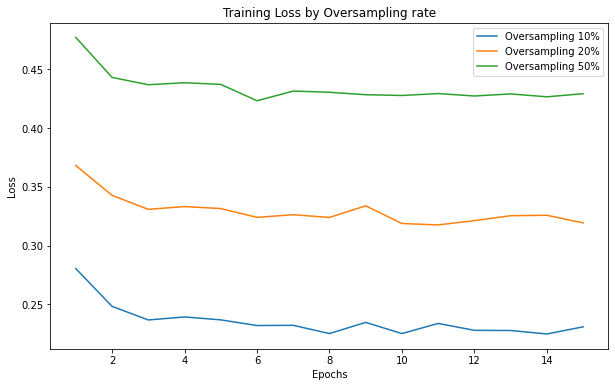

In [63]:
# Training loss by oversampling
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os1_train_results['train_loss']) + 1)
plt.plot(epoch_count, (e15_tb05_os1_train_results['train_loss']), label='Oversampling 10%')
plt.plot(epoch_count, (e15_tb05_os2_train_results['train_loss']), label='Oversampling 20%')
plt.plot(epoch_count, (e15_tb05_os5_train_results['train_loss']), label='Oversampling 50%')
plt.title("Training Loss by Oversampling rate", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

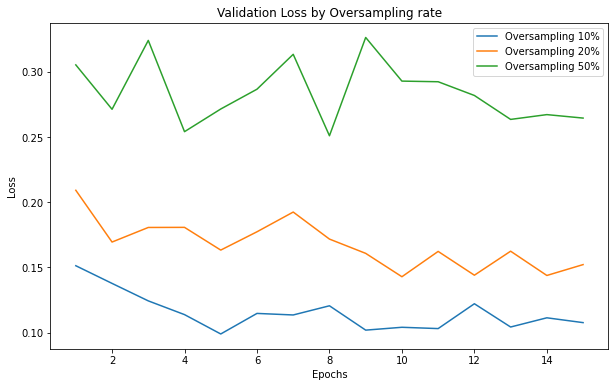

In [64]:
# Validation loss by oversampling - NOTE: Only training data is oversampled not validation
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os1_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e15_tb05_os1_train_results['val_loss']), label='Oversampling 10%')
plt.plot(epoch_count, (e15_tb05_os2_train_results['val_loss']), label='Oversampling 20%')
plt.plot(epoch_count, (e15_tb05_os5_train_results['val_loss']), label='Oversampling 50%')
plt.title("Validation Loss by Oversampling rate", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

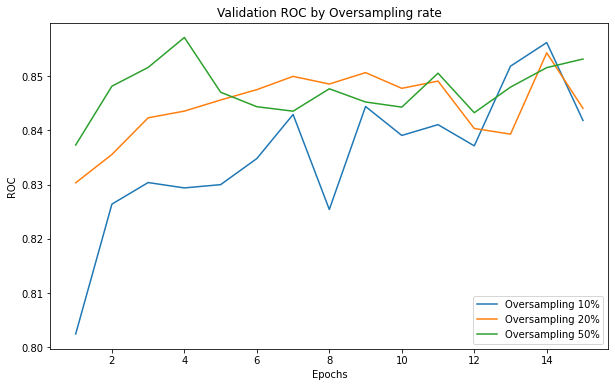

In [65]:
# Validation ROC by oversampling
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os1_train_results['val_roc']) + 1)
plt.plot(epoch_count, (e15_tb05_os1_train_results['val_roc']), label='Oversampling 10%')
plt.plot(epoch_count, (e15_tb05_os2_train_results['val_roc']), label='Oversampling 20%')
plt.plot(epoch_count, (e15_tb05_os5_train_results['val_roc']), label='Oversampling 50%')
plt.title("Validation ROC by Oversampling rate", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

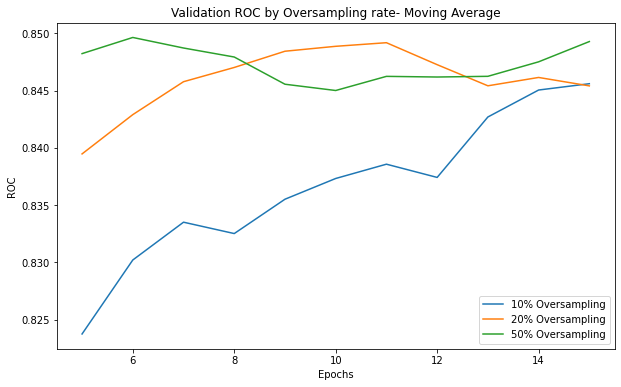

In [184]:

# Validation ROC by oversampling - MOVING AVERAGE

fig=plt.figure(figsize=(10,6))
w=5
ma_val_roc_10 = moving_average(e15_tb05_os1_train_results['val_roc'],w)
ma_val_roc_20 = moving_average(e15_tb05_os2_train_results['val_roc'],w)
ma_val_roc_50 = moving_average(e15_tb05_os5_train_results['val_roc'],w)
ma_e_count = range(w, len(ma_val_roc_10)+w)
plt.plot(ma_e_count, ma_val_roc_10, label='10% Oversampling')
plt.plot(ma_e_count, ma_val_roc_20, label='20% Oversampling')
plt.plot(ma_e_count, ma_val_roc_50, label='50% Oversampling')
plt.title("Validation ROC by Oversampling rate- Moving Average", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()



Conclusion:
* Difference in loss can be related to having an increase in Melanoma target samples in the data.
* The probability of oversampling more than 20% leads to faster convergence, improved ROC results.
* Although 50% oversampling achieves better performance we will progress with 20% as we do not want to overrepresent target 1 by unrealistic class oversampling. Will return to explore oversampling in federated learning.




## Investigating addition of Dropout layers in classifier architecture

In [89]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [92]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNetDropout(model='efficientnet-b0')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() 
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [93]:
# Run training/validation Melanoma EfficientNet

Melanoma_Base_Epoch15_b32_tb05_os2_lr4_dp= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Base_Epoch15_b32_tb05_os2_lr4_dp")


 epoch: 0, train loss: 0.375381, val loss: 0.199206, train acc: 0.8417, val acc: 0.9392, val roc:0.8294



 epoch: 1, train loss: 0.344801, val loss: 0.158558, train acc: 0.8502, val acc: 0.9586, val roc:0.8401



 epoch: 2, train loss: 0.333459, val loss: 0.168287, train acc: 0.8547, val acc: 0.9556, val roc:0.8370



 epoch: 3, train loss: 0.333235, val loss: 0.181139, train acc: 0.8523, val acc: 0.9501, val roc:0.8428



 epoch: 4, train loss: 0.332681, val loss: 0.160595, train acc: 0.8512, val acc: 0.9550, val roc:0.8504



 epoch: 5, train loss: 0.323300, val loss: 0.175733, train acc: 0.8591, val acc: 0.9497, val roc:0.8458



 epoch: 6, train loss: 0.326878, val loss: 0.173380, train acc: 0.8523, val acc: 0.9553, val roc:0.8459



 epoch: 7, train loss: 0.325691, val loss: 0.148957, train acc: 0.8574, val acc: 0.9684, val roc:0.8411



 epoch: 8, train loss: 0.333455, val loss: 0.158389, train acc: 0.8518, val acc: 0.9583, val roc:0.8445



 epoch: 9, train loss: 0.319151, val loss: 0.142433, train acc: 0.8586, val acc: 0.9632, val roc:0.8383



 epoch: 10, train loss: 0.320582, val loss: 0.160649, train acc: 0.8559, val acc: 0.9545, val roc:0.8497



 epoch: 11, train loss: 0.321104, val loss: 0.142596, train acc: 0.8570, val acc: 0.9632, val roc:0.8419



 epoch: 12, train loss: 0.326766, val loss: 0.162722, train acc: 0.8539, val acc: 0.9553, val roc:0.8448



 epoch: 13, train loss: 0.323922, val loss: 0.146042, train acc: 0.8545, val acc: 0.9591, val roc:0.8547



 epoch: 14, train loss: 0.318095, val loss: 0.155501, train acc: 0.8569, val acc: 0.9580, val roc:0.8430
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_lr4_dp.pth.tar saved.
Training Finished
Training and validation time: 9115.009266376495 seconds


In [153]:
# Test run
Melanoma_model= MelanomaEfficientNetDropout(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_lr4_dp.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNetDropout(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_pad

In [154]:
drp_e15_tb05_os2_test_results, drp_e15_tb05_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [130]:
drp_e15_tb05_os2_test_results

{'test_accuracy': 0.9577340769004989,
 'test_roc_score': 0.8287432596643123,
 'CM': array([[3247,   97],
        [  47,   16]], dtype=int64)}

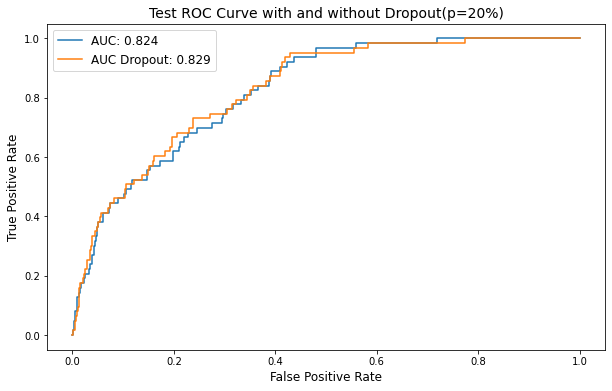

In [155]:
# Comparing Test ROC dropout vs normal model architecture- with 50% Data augmentation probability and 20% oversampling, lr 1e-4

fig=plt.figure(figsize=(10,6))
AUC="{:.3f}".format(e15_tb05_os2_roc_curve_stat['AUC'])
AUC_dropout="{:.3f}".format(drp_e15_tb05_os2_roc_curve_stat['AUC'])
score= "AUC: " + str(AUC)
score_dropout= "AUC Dropout: " + str(AUC_dropout)
plt.plot(e15_tb05_os2_roc_curve_stat['fpr'],e15_tb05_os2_roc_curve_stat['tpr'], label=score)
plt.plot(drp_e15_tb05_os2_roc_curve_stat['fpr'],drp_e15_tb05_os2_roc_curve_stat['tpr'], label=score_dropout)
plt.title("Test ROC Curve with and without Dropout(p=20%)", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

In [186]:
# Load results
e15_tb05_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2.pth.tar")
drp_e15_tb05_os2_train_results= load_results("TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_lr4_dp.pth.tar")

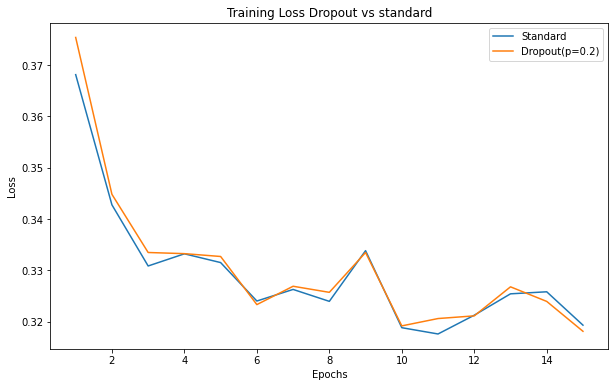

In [187]:
# Training loss dropout vs standard
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os2_train_results['train_loss']) + 1)
plt.plot(epoch_count, (e15_tb05_os2_train_results['train_loss']), label='Standard')
plt.plot(epoch_count, (drp_e15_tb05_os2_train_results['train_loss']), label='Dropout(p=0.2)')
plt.title("Training Loss Dropout vs standard", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

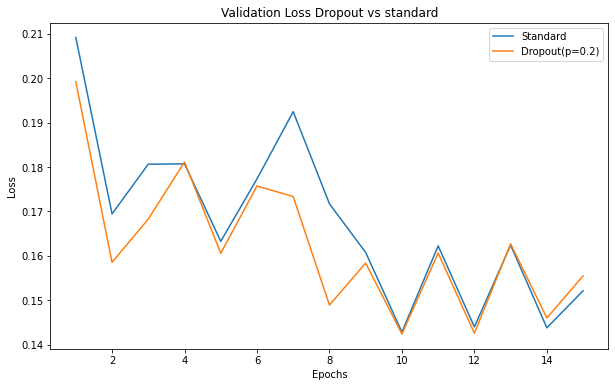

In [188]:
# Validation loss dropout vs standard
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os2_train_results['val_loss']) + 1)
plt.plot(epoch_count, (e15_tb05_os2_train_results['val_loss']), label='Standard')
plt.plot(epoch_count, (drp_e15_tb05_os2_train_results['val_loss']), label='Dropout(p=0.2)')
plt.title("Validation Loss Dropout vs standard", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

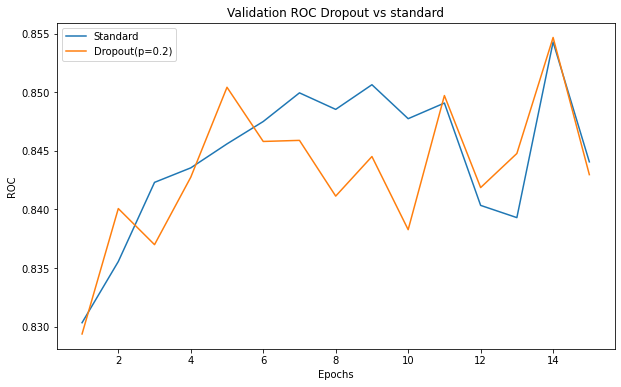

In [189]:
# Validation ROC dropout vs standard
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(e15_tb05_os2_train_results['val_roc']) + 1)
plt.plot(epoch_count, (e15_tb05_os2_train_results['val_roc']), label='Standard')
plt.plot(epoch_count, (drp_e15_tb05_os2_train_results['val_roc']), label='Dropout(p=0.2)')
plt.title("Validation ROC Dropout vs standard", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

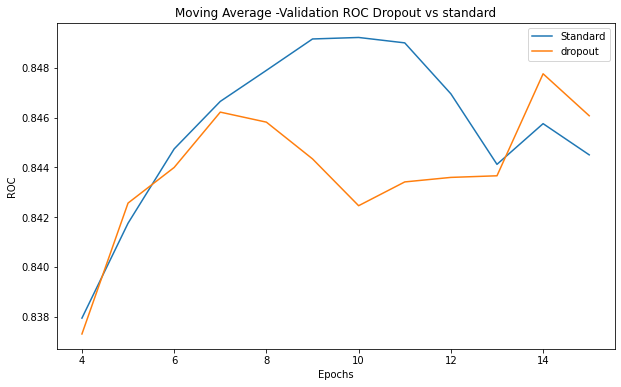

In [192]:
# mOVING Average - Validation ROC dropout vs standard

fig=plt.figure(figsize=(10,6))
w=4
ma_val_roc = moving_average(e15_tb05_os2_train_results['val_roc'],w)
ma_val_roc_drp = moving_average(drp_e15_tb05_os2_train_results['val_roc'],w)
ma_e_count = range(w, len(ma_val_roc)+w)
plt.plot(ma_e_count, ma_val_roc, label='Standard')
plt.plot(ma_e_count, ma_val_roc_drp, label='dropout')
plt.title("Moving Average -Validation ROC Dropout vs standard", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

Conclusion: 
* No significant increase in the performance of the model with dropout, training loss does appear slightly more stable. 

### Investigating EfficientNet-B1 model to determine the impact of scaling the pretrained model.

In [94]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, 
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [97]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b1')
model= Melanoma_model
criterion=nn.BCEWithLogitsLoss() # or BCELoss(need to apply additional sigmoid) or Focal Loss
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b1


In [98]:
# Run training/validation Melanoma EfficientNet

Melanoma_B1_Epoch15_b32_tb05_os2_lr4= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="B1_Epoch15_b32_tb05_os2_lr4")


 epoch: 0, train loss: 0.383525, val loss: 0.252558, train acc: 0.8412, val acc: 0.9166, val roc:0.8354



 epoch: 1, train loss: 0.354969, val loss: 0.171317, train acc: 0.8482, val acc: 0.9606, val roc:0.8344



 epoch: 2, train loss: 0.345190, val loss: 0.184730, train acc: 0.8491, val acc: 0.9498, val roc:0.8445



 epoch: 3, train loss: 0.346502, val loss: 0.187357, train acc: 0.8477, val acc: 0.9509, val roc:0.8323



 epoch: 4, train loss: 0.348371, val loss: 0.170593, train acc: 0.8479, val acc: 0.9518, val roc:0.8558



 epoch: 5, train loss: 0.337817, val loss: 0.179741, train acc: 0.8520, val acc: 0.9518, val roc:0.8444



 epoch: 6, train loss: 0.340058, val loss: 0.198392, train acc: 0.8489, val acc: 0.9480, val roc:0.8364



 epoch: 7, train loss: 0.341883, val loss: 0.184607, train acc: 0.8484, val acc: 0.9495, val roc:0.8491



 epoch: 8, train loss: 0.346648, val loss: 0.175074, train acc: 0.8468, val acc: 0.9563, val roc:0.8457



 epoch: 9, train loss: 0.333283, val loss: 0.153984, train acc: 0.8510, val acc: 0.9591, val roc:0.8410



 epoch: 10, train loss: 0.332912, val loss: 0.172342, train acc: 0.8528, val acc: 0.9493, val roc:0.8429



 epoch: 11, train loss: 0.333533, val loss: 0.158876, train acc: 0.8511, val acc: 0.9580, val roc:0.8430



 epoch: 12, train loss: 0.337834, val loss: 0.174202, train acc: 0.8482, val acc: 0.9489, val roc:0.8482



 epoch: 13, train loss: 0.337410, val loss: 0.152126, train acc: 0.8512, val acc: 0.9633, val roc:0.8509



 epoch: 14, train loss: 0.331751, val loss: 0.138438, train acc: 0.8554, val acc: 0.9662, val roc:0.8470
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_B1_Epoch15_b32_tb05_os2_lr4.pth.tar saved.
Training Finished
Training and validation time: 9315.152609825134 seconds


In [193]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b1')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_B1_Epoch15_b32_tb05_os2_lr4.pth.tar")

Loaded pretrained weights for efficientnet-b1
Loading checkpoint ... 


(MelanomaEfficientNet(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): 

In [194]:
B1_e15_tb05_os2_test_results, B1_e15_tb05_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [195]:
B1_e15_tb05_os2_test_results

{'test_accuracy': 0.9677135309656589,
 'test_roc_score': 0.7915147717779296,
 'CM': array([[3286,   58],
        [  52,   11]], dtype=int64)}

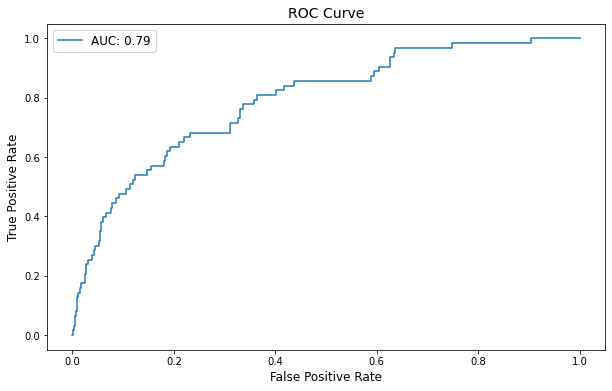

In [197]:
plot_roc(B1_e15_tb05_os2_roc_curve_stat, title="ROC Curve")

In [203]:
# load results

B1_e15_tb05_os2_train_results=load_results("TrainedEffNetcheckpoint_B1_Epoch15_b32_tb05_os2_lr4.pth.tar")
B0_e15_tb05_os2_train_results=load_results("TrainedEffNetcheckpoint_Epoch15_b32_tb05_os2.pth.tar")


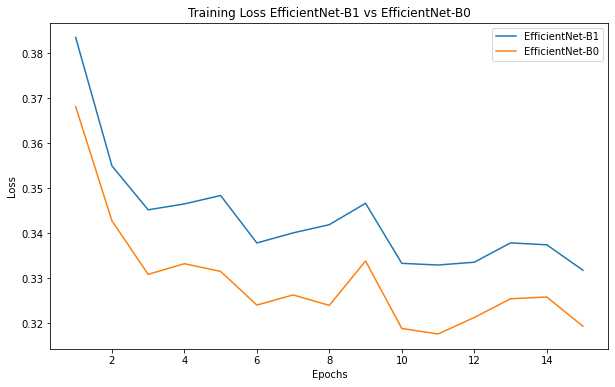

In [204]:
# Training loss B1 model
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(B1_e15_tb05_os2_train_results['train_loss']) + 1)
plt.plot(epoch_count, (B1_e15_tb05_os2_train_results['train_loss']), label='EfficientNet-B1')
plt.plot(epoch_count, (B0_e15_tb05_os2_train_results['train_loss']), label='EfficientNet-B0')
plt.title("Training Loss EfficientNet-B1 vs EfficientNet-B0", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

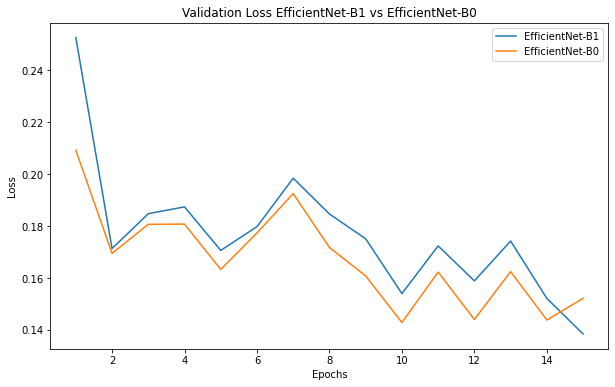

In [205]:
# Validation loss B1 model
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(B1_e15_tb05_os2_train_results['val_loss']) + 1)
plt.plot(epoch_count, (B1_e15_tb05_os2_train_results['val_loss']), label='EfficientNet-B1')
plt.plot(epoch_count, (B0_e15_tb05_os2_train_results['val_loss']), label='EfficientNet-B0')
plt.title("Validation Loss EfficientNet-B1 vs EfficientNet-B0", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

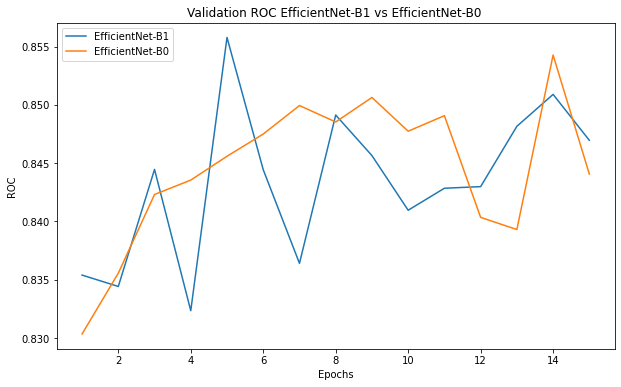

In [206]:
# Validation ROC B1 model
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(B1_e15_tb05_os2_train_results['val_roc']) + 1)
plt.plot(epoch_count, (B1_e15_tb05_os2_train_results['val_roc']), label='EfficientNet-B1')
plt.plot(epoch_count, (B0_e15_tb05_os2_train_results['val_roc']), label='EfficientNet-B0')
plt.title("Validation ROC EfficientNet-B1 vs EfficientNet-B0 ", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

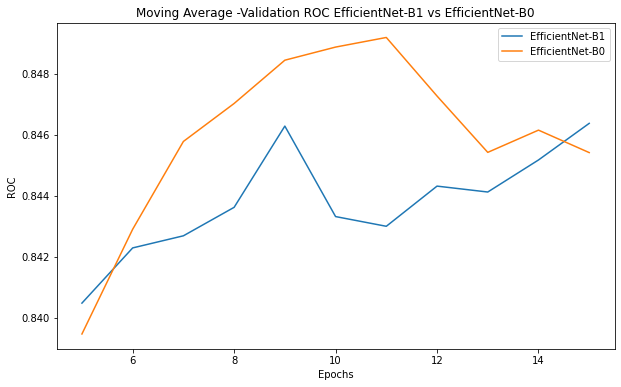

In [208]:
# Moving Average- Validation ROC B1 model

fig=plt.figure(figsize=(10,6))
w=5
ma_val_roc_b1 = moving_average(B1_e15_tb05_os2_train_results['val_roc'],w)
ma_val_roc_b0 = moving_average(B0_e15_tb05_os2_train_results['val_roc'],w)
ma_e_count = range(w, len(ma_val_roc_b1)+w)
plt.plot(ma_e_count, ma_val_roc_b1, label='EfficientNet-B1')
plt.plot(ma_e_count, ma_val_roc_b0, label='EfficientNet-B0')
plt.title("Moving Average -Validation ROC EfficientNet-B1 vs EfficientNet-B0", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()

Conclusion: 
* EfficientNet-B1 seems to be underperforming, this may be due to the fact it expects a larger image as input (240 x 240).
* Validation ROC appears more unstable for EfficientNet-B1.
* ROC test results surprisingly lower than validation ROC


### Investigating a loss function for imbalanced data 

### Focal Loss on classifier 

In [68]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.5,dataseed=0)

# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set, test_set=test_set, 
                                                          batch_size=32, oversampling_ratio=0.2)

# Hyperparameters 
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15

In [69]:
# Instantiate Model
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model
criterion=FocalLoss()# or BCELoss(need to apply additional sigmoid) or Focal Loss
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0


In [70]:
# Run training/validation Melanoma EfficientNet

Melanoma_Focal_Epoch15_b32_tb05_os2_lr4= train_val_clip(model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,checkpoint_name="Focal_Epoch15_b32_tb05_os2_lr4")


 epoch: 0, train loss: 0.093888, val loss: 0.054262, train acc: 0.8456, val acc: 0.9367, val roc:0.8316



 epoch: 1, train loss: 0.089177, val loss: 0.047790, train acc: 0.8491, val acc: 0.9585, val roc:0.8400



 epoch: 2, train loss: 0.086358, val loss: 0.051058, train acc: 0.8515, val acc: 0.9437, val roc:0.8435



 epoch: 3, train loss: 0.087032, val loss: 0.050631, train acc: 0.8510, val acc: 0.9465, val roc:0.8454



 epoch: 4, train loss: 0.086612, val loss: 0.044398, train acc: 0.8480, val acc: 0.9541, val roc:0.8459



 epoch: 5, train loss: 0.084890, val loss: 0.049171, train acc: 0.8557, val acc: 0.9474, val roc:0.8452



 epoch: 6, train loss: 0.085385, val loss: 0.052384, train acc: 0.8535, val acc: 0.9419, val roc:0.8473



 epoch: 7, train loss: 0.084770, val loss: 0.046076, train acc: 0.8533, val acc: 0.9609, val roc:0.8477



 epoch: 8, train loss: 0.087200, val loss: 0.044443, train acc: 0.8469, val acc: 0.9576, val roc:0.8501



 epoch: 9, train loss: 0.083367, val loss: 0.039064, train acc: 0.8560, val acc: 0.9653, val roc:0.8456



 epoch: 10, train loss: 0.083228, val loss: 0.044513, train acc: 0.8570, val acc: 0.9492, val roc:0.8489



 epoch: 11, train loss: 0.084183, val loss: 0.039374, train acc: 0.8535, val acc: 0.9630, val roc:0.8403



 epoch: 12, train loss: 0.085173, val loss: 0.043587, train acc: 0.8528, val acc: 0.9557, val roc:0.8374



 epoch: 13, train loss: 0.085166, val loss: 0.039353, train acc: 0.8519, val acc: 0.9582, val roc:0.8519



 epoch: 14, train loss: 0.083641, val loss: 0.042030, train acc: 0.8576, val acc: 0.9611, val roc:0.8424
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Focal_Epoch15_b32_tb05_os2_lr4.pth.tar saved.
Training Finished
Training and validation time: 10333.134978055954 seconds


In [209]:
# Test run
Melanoma_model= MelanomaEfficientNet(model='efficientnet-b0')
model= Melanoma_model

# Load trained model
learning_rate = 1e-4
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model, optimizer, load_checkpoint_path="TrainedEffNetcheckpoint_Focal_Epoch15_b32_tb05_os2_lr4.pth.tar")

Loaded pretrained weights for efficientnet-b0
Loading checkpoint ... 


(MelanomaEfficientNetDropout(
   (backbone): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_pad

In [210]:
Focal_e15_tb05_os2_test_results, Focal_e15_tb05_os2_roc_curve_stat = test(model, test_loader=test_loader, device=device)

In [213]:
Focal_e15_tb05_os2_test_results

{'test_accuracy': 0.9586146169650719,
 'test_roc_score': 0.8278603706235286,
 'CM': array([[3251,   93],
        [  48,   15]], dtype=int64)}

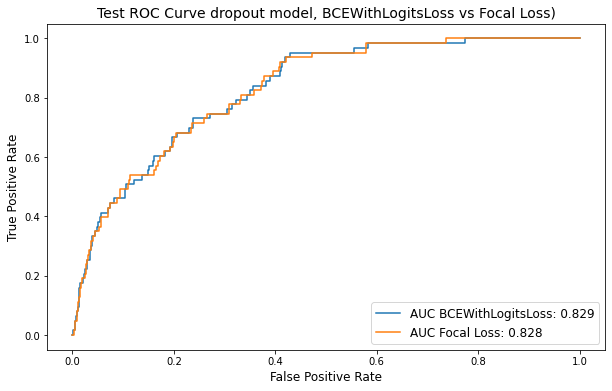

In [212]:
# Comparing Test ROC dropout vs dropout using Focal Loss- with 50% Data augmentation probability and 20% oversampling, lr 1e-4

fig=plt.figure(figsize=(10,6))
AUC="{:.3f}".format(drp_e15_tb05_os2_roc_curve_stat['AUC'])
AUC_focal="{:.3f}".format(Focal_e15_tb05_os2_roc_curve_stat['AUC'])
score= "AUC BCEWithLogitsLoss: " + str(AUC)
score_focal= "AUC Focal Loss: " + str(AUC_focal)
plt.plot(drp_e15_tb05_os2_roc_curve_stat['fpr'],drp_e15_tb05_os2_roc_curve_stat['tpr'], label=score)
plt.plot(Focal_e15_tb05_os2_roc_curve_stat['fpr'],Focal_e15_tb05_os2_roc_curve_stat['tpr'], label=score_focal)
plt.title("Test ROC Curve model, BCEWithLogitsLoss vs Focal Loss)", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

In [214]:
# load results
drp_e15_tb05_os2_train_results= load_results("TrainedEffNetcheckpoint_Base_Epoch15_b32_tb05_os2_lr4_dp.pth.tar")
Focal_e15_tb05_os2_train_results=load_results("TrainedEffNetcheckpoint_FocalDrp_Epoch15_b32_tb05_os2_lr4.pth.tar")

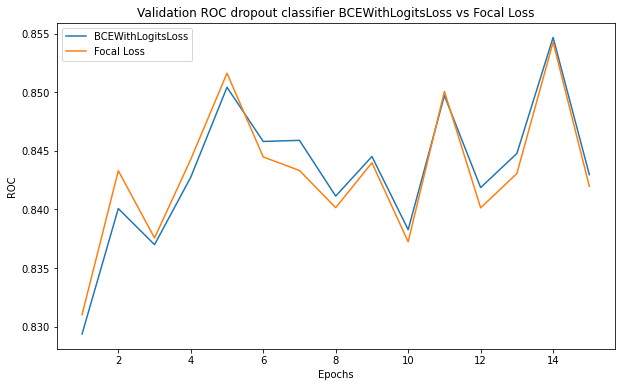

In [217]:
# Val ROC BCEWithLogitsLoss VS Focal Loss
fig=plt.figure(figsize=(10,6))
epoch_count = range(1, len(drp_e15_tb05_os2_train_results['val_roc']) + 1)
plt.plot(epoch_count, (drp_e15_tb05_os2_train_results['val_roc']), label='BCEWithLogitsLoss')
plt.plot(epoch_count, (Focal_e15_tb05_os2_train_results['val_roc']), label='Focal Loss')
plt.title("Validation ROC dropout classifier BCEWithLogitsLoss vs Focal Loss", fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("ROC")
plt.legend(fontsize=10)
plt.show()